# Import libraries and load dataset

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10


In [2]:
df = pd.read_csv(Path('../data/PRSA_data_2010.1.1-2014.12.31_Beijing.csv'))

# Create data to give as an input to the network: continuous sequences of 100 data with no NaN

In [3]:
# Funzione per identificare sequenze continue senza missing
def find_continuous_sequences(series, min_length=100):
    """
    Identifica sequenze continue di valori non-missing di lunghezza >= min_length.
    
    Parameters:
    -----------
    series : pd.Series
        Serie temporale da analizzare
    min_length : int
        Lunghezza minima della sequenza continua
    
    Returns:
    --------
    list of tuples : [(start_idx, end_idx, length), ...]
        Lista di tuple con indici di inizio, fine e lunghezza di ogni sequenza
    """
    sequences = []
    start_idx = None
    current_length = 0
    
    for idx in range(len(series)):
        if pd.notna(series.iloc[idx]):
            # Valore valido
            if start_idx is None:
                start_idx = idx
                current_length = 1
            else:
                current_length += 1
        else:
            # Missing value - salva sequenza se abbastanza lunga
            if start_idx is not None and current_length >= min_length:
                sequences.append((start_idx, idx - 1, current_length))
            start_idx = None
            current_length = 0
    
    # Controlla l'ultima sequenza
    if start_idx is not None and current_length >= min_length:
        sequences.append((start_idx, len(series) - 1, current_length))
    
    return sequences

# Crea indice datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Trova sequenze continue di PM2.5
min_sequence_length = 100
continuous_sequences = find_continuous_sequences(df['pm2.5'], min_length=min_sequence_length)

print(f"\n SEQUENZE CONTINUE (≥ {min_sequence_length} valori consecutivi senza missing)\n")
print("=" * 90)
print(f"{'#':<5} {'Inizio':<22} {'Fine':<22} {'Lunghezza':<12} {'% Dataset':<12}")
print("=" * 90)

total_continuous_values = 0
for i, (start_idx, end_idx, length) in enumerate(continuous_sequences, 1):
    start_date = df.index[start_idx]
    end_date = df.index[end_idx]
    pct = length / len(df) * 100
    print(f"{i:<5} {str(start_date):<22} {str(end_date):<22} {length:<12,} {pct:<12.2f}%")
    total_continuous_values += length

print("=" * 90)
print(f"\nStatistiche:")
print(f"   Numero sequenze trovate:     {len(continuous_sequences)}")
print(f"   Totale valori in sequenze:   {total_continuous_values:,}")
print(f"   % dataset utilizzabile:      {total_continuous_values/len(df)*100:.2f}%")
print(f"   Media lunghezza sequenza:    {total_continuous_values/len(continuous_sequences):.0f} valori")
print(f"   Sequenza più lunga:          {max([s[2] for s in continuous_sequences]):,} valori")
print(f"   Sequenza più corta:          {min([s[2] for s in continuous_sequences]):,} valori")


 SEQUENZE CONTINUE (≥ 100 valori consecutivi senza missing)

#     Inizio                 Fine                   Lunghezza    % Dataset   
1     2010-01-02 00:00:00    2010-01-23 16:00:00    521          1.19        %
2     2010-01-26 12:00:00    2010-02-14 01:00:00    446          1.02        %
3     2010-02-14 03:00:00    2010-03-20 04:00:00    818          1.87        %
4     2010-03-23 00:00:00    2010-03-30 05:00:00    174          0.40        %
5     2010-04-01 13:00:00    2010-05-17 16:00:00    1,108        2.53        %
6     2010-05-17 19:00:00    2010-05-27 18:00:00    240          0.55        %
7     2010-05-28 00:00:00    2010-06-01 15:00:00    112          0.26        %
8     2010-06-09 17:00:00    2010-06-20 07:00:00    255          0.58        %
9     2010-06-23 10:00:00    2010-08-13 19:00:00    1,234        2.82        %
10    2010-08-16 16:00:00    2010-09-11 05:00:00    614          1.40        %
11    2010-09-11 22:00:00    2010-09-19 18:00:00    189          0.43 

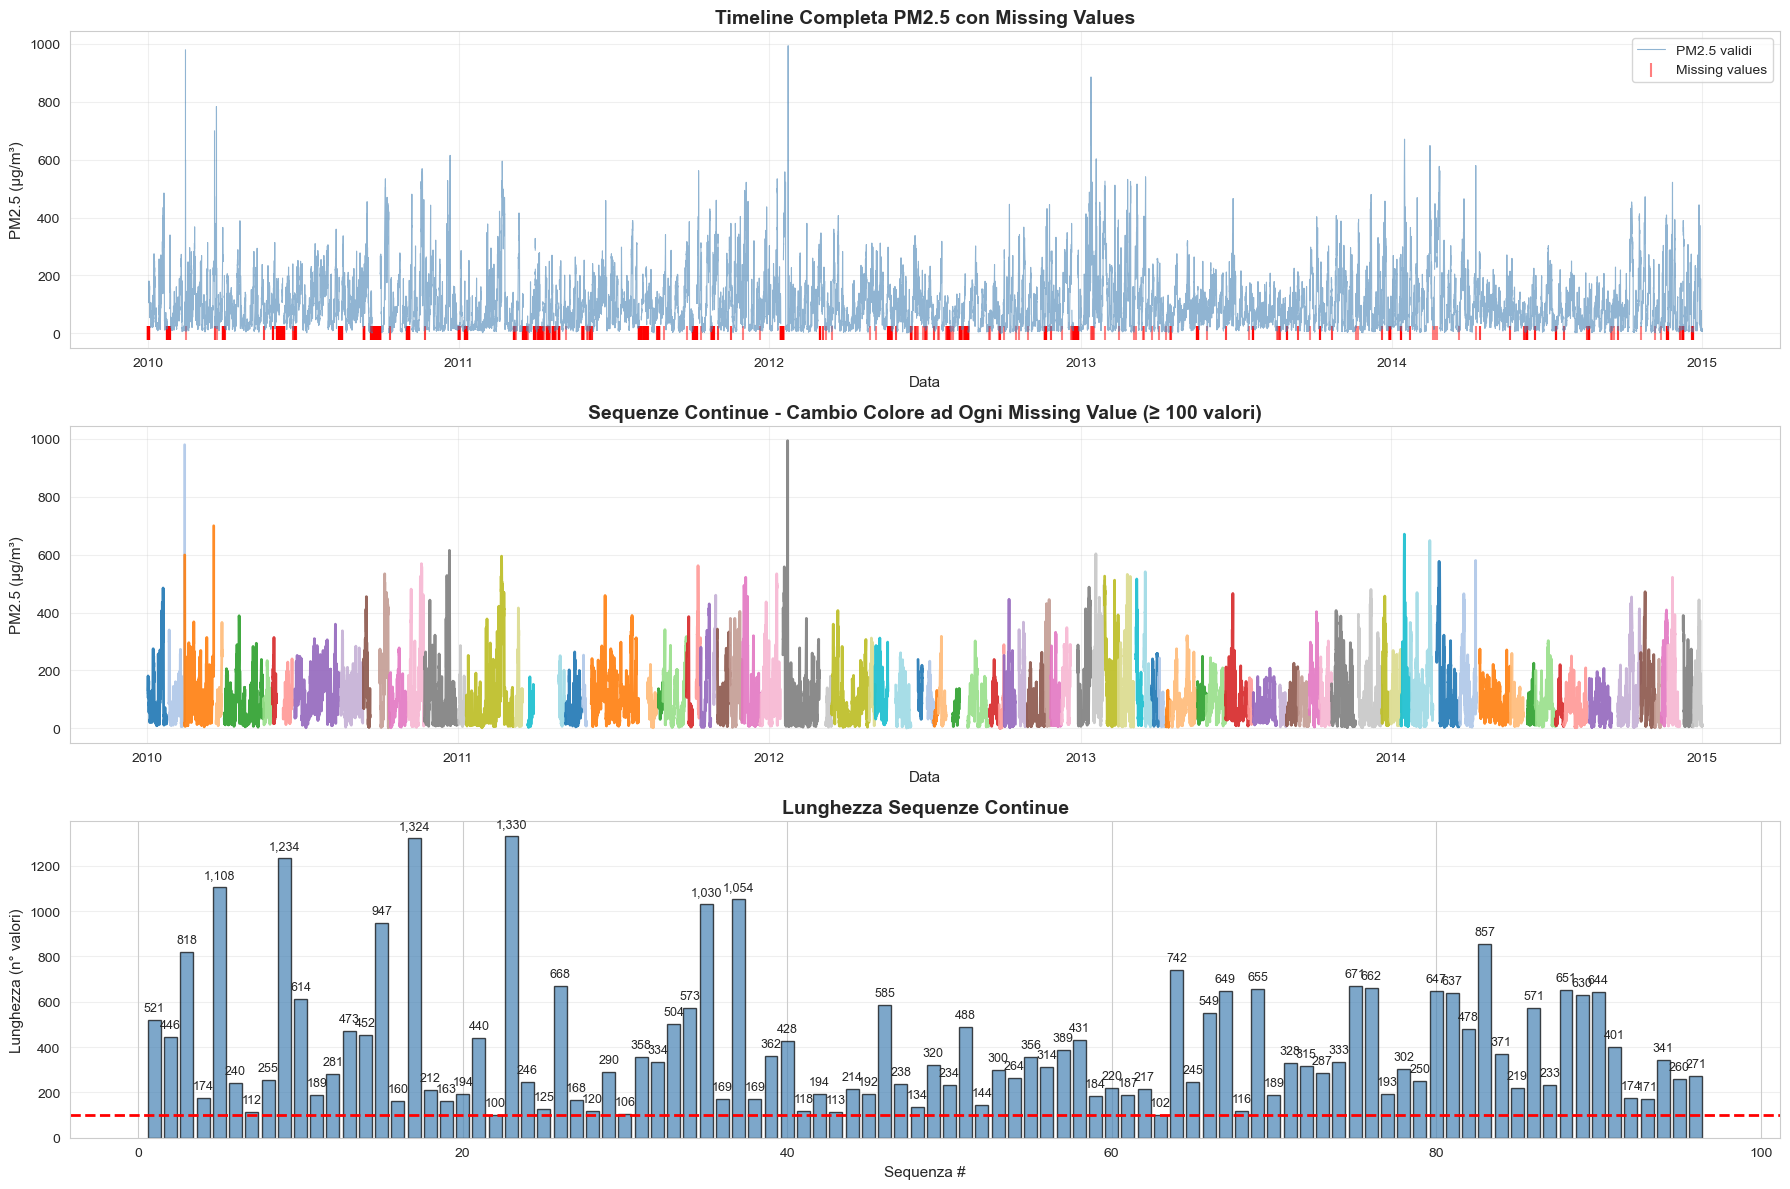

In [ ]:
# Visualizzazione sequenze continue
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# 1. Timeline completa con missing values evidenziati
ax1 = axes[0]
ax1.plot(df.index, df['pm2.5'], alpha=0.6, linewidth=0.8, color='steelblue', label='PM2.5 validi')

# Evidenzia missing values
missing_mask = df['pm2.5'].isnull()
if missing_mask.any():
    missing_indices = df.index[missing_mask]
    ax1.scatter(missing_indices, [0] * len(missing_indices), 
               color='red', marker='|', s=100, alpha=0.5, label='Missing values')

ax1.set_title('Complete timeline of PM2.5 with Missing Values', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('PM2.5 [μg/m³]', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Sequenze continue evidenziate con cambio colore ad ogni sequenza
ax2 = axes[1]

palette = plt.cm.tab20.colors  # 20 colori distinti
n_colors = len(palette)

for i, (start_idx, end_idx, length) in enumerate(continuous_sequences):
    seq_data = df['pm2.5'].iloc[start_idx:end_idx+1]
    # Usa il modulo per ciclare sui colori
    color = palette[i % n_colors]
    ax2.plot(seq_data.index, seq_data.values, 
            linewidth=2, color=color, alpha=0.9)

ax2.set_title(f'Continuous Sequences - Color Change at Each Missing Value (≥ {min_sequence_length} values)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('PM2.5 [μg/m³]', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Distribuzione lunghezze sequenze
ax3 = axes[2]
sequence_lengths = [s[2] for s in continuous_sequences]
ax3.bar(range(1, len(sequence_lengths) + 1), sequence_lengths, 
       color='steelblue', edgecolor='black', alpha=0.7)
ax3.axhline(y=min_sequence_length, color='red', linestyle='--', 
           linewidth=2, label=f'Minimum Threshold ({min_sequence_length})')
ax3.set_title('Length of Continuous Sequences', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sequence #', fontsize=11)
ax3.set_ylabel('Length (number of values)', fontsize=11)
#ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Aggiungi valori sopra le barre
for i, length in enumerate(sequence_lengths):
    ax3.text(i + 1, length + max(sequence_lengths)*0.02, 
            f'{length:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(Path('../figures/prediction/continuous_sequences_analysis.pdf'))
plt.show()

In [5]:
# Estrai dati dalle sequenze continue
def extract_continuous_data(dataframe, sequences):
    """
    Estrae i dati dalle sequenze continue e li concatena.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        DataFrame originale
    sequences : list of tuples
        Lista di sequenze (start_idx, end_idx, length)
    
    Returns:
    --------
    pd.DataFrame : DataFrame con solo le sequenze continue
    list : Lista di tuple (seq_id, start_pos, end_pos) per tracciare le sequenze
    """
    continuous_chunks = []
    sequence_info = []
    current_position = 0
    
    for seq_id, (start_idx, end_idx, length) in enumerate(sequences, 1):
        chunk = dataframe.iloc[start_idx:end_idx+1].copy()
        chunk['sequence_id'] = seq_id  # Traccia da quale sequenza proviene
        continuous_chunks.append(chunk)
        
        # Salva informazioni sulla posizione nel nuovo dataset
        sequence_info.append({
            'seq_id': seq_id,
            'original_start': start_idx,
            'original_end': end_idx,
            'new_start': current_position,
            'new_end': current_position + length - 1,
            'length': length,
            'date_start': dataframe.index[start_idx],
            'date_end': dataframe.index[end_idx]
        })
        current_position += length
    
    # Concatena tutte le sequenze
    continuous_df = pd.concat(continuous_chunks, axis=0)
    
    return continuous_df, sequence_info

# Estrai dati continui
df_continuous, seq_info = extract_continuous_data(df, continuous_sequences)

print("Dataset Continuo Estratto\n")
print("=" * 90)
print(f"Shape dataset originale:    {df.shape}")
print(f"Shape dataset continuo:     {df_continuous.shape}")
print(f"Righe mantenute:            {len(df_continuous):,} ({len(df_continuous)/len(df)*100:.2f}%)")
print("=" * 90)

print(f"\nInformazioni Sequenze nel Dataset Continuo:")
print("=" * 90)
print(f"{'Seq':<5} {'Inizio Originale':<20} {'Fine Originale':<20} {'Pos. Nuovo Dataset':<25} {'Lunghezza':<12}")
print("=" * 90)
for info in seq_info:
    pos_range = f"{info['new_start']} - {info['new_end']}"
    print(f"{info['seq_id']:<5} {str(info['date_start']):<20} {str(info['date_end']):<20} "
          f"{pos_range:<25} {info['length']:<12,}")
print("=" * 90)

# Verifica che non ci siano missing nel dataset continuo
missing_in_continuous = df_continuous['pm2.5'].isnull().sum()
print(f"\nVerifica: Missing PM2.5 nel dataset continuo: {missing_in_continuous}")

Dataset Continuo Estratto

Shape dataset originale:    (43824, 13)
Shape dataset continuo:     (38471, 14)
Righe mantenute:            38,471 (87.79%)

Informazioni Sequenze nel Dataset Continuo:
Seq   Inizio Originale     Fine Originale       Pos. Nuovo Dataset        Lunghezza   
1     2010-01-02 00:00:00  2010-01-23 16:00:00  0 - 520                   521         
2     2010-01-26 12:00:00  2010-02-14 01:00:00  521 - 966                 446         
3     2010-02-14 03:00:00  2010-03-20 04:00:00  967 - 1784                818         
4     2010-03-23 00:00:00  2010-03-30 05:00:00  1785 - 1958               174         
5     2010-04-01 13:00:00  2010-05-17 16:00:00  1959 - 3066               1,108       
6     2010-05-17 19:00:00  2010-05-27 18:00:00  3067 - 3306               240         
7     2010-05-28 00:00:00  2010-06-01 15:00:00  3307 - 3418               112         
8     2010-06-09 17:00:00  2010-06-20 07:00:00  3419 - 3673               255         
9     2010-06-23 10:0

In [6]:
# Funzione per creare finestre temporali (sliding window)
def create_sequences_from_continuous(data, sequence_info, window_size=24, forecast_horizon=1, 
                                     features=None, target='pm2.5'):
    """
    Crea finestre temporali dalle sequenze continue, rispettando i confini delle sequenze.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con le sequenze continue
    sequence_info : list of dict
        Informazioni sulle sequenze
    window_size : int
        Dimensione della finestra di input (numero di timesteps passati)
    forecast_horizon : int
        Orizzonte di previsione (numero di timesteps futuri da predire)
    features : list
        Lista di feature da usare (se None, usa tutte tranne target)
    target : str
        Nome della colonna target
    
    Returns:
    --------
    X : np.array
        Array di input shape (n_samples, window_size, n_features)
    y : np.array
        Array di target shape (n_samples, forecast_horizon)
    window_info : list
        Informazioni su ogni finestra (per debugging/analisi)
    """
    if features is None:
        # Usa tutte le feature tranne target e sequence_id
        features = [col for col in data.columns if col not in [target, 'sequence_id']]
    
    X_list = []
    y_list = []
    window_info = []
    
    total_windows = 0
    
    # Processa ogni sequenza separatamente
    for seq in sequence_info:
        seq_id = seq['seq_id']
        start_pos = seq['new_start']
        end_pos = seq['new_end']
        seq_length = seq['length']
        
        # Estrai dati della sequenza
        seq_data = data.iloc[start_pos:end_pos+1]
        
        # Calcola quante finestre possiamo creare da questa sequenza
        max_windows = seq_length - window_size - forecast_horizon + 1
        
        if max_windows <= 0:
            print(f"Sequenza {seq_id} troppo corta ({seq_length}) per creare finestre "
                  f"(necessari almeno {window_size + forecast_horizon})")
            continue
        
        # Crea finestre dalla sequenza
        for i in range(max_windows):
            # Finestra di input
            window_start = i
            window_end = i + window_size
            
            # Valore/i da predire
            target_start = window_end
            target_end = window_end + forecast_horizon
            
            # Estrai dati
            X_window = seq_data[features].iloc[window_start:window_end].values
            y_window = seq_data[target].iloc[target_start:target_end].values
            
            # Verifica che non ci siano NaN (controlla solo se numeric)
            has_nan = False
            try:
                has_nan = np.isnan(X_window).any() or np.isnan(y_window).any()
            except TypeError:
                # Se non è numerico, usa pandas
                has_nan = pd.isna(X_window).any() or pd.isna(y_window).any()
            
            if not has_nan:
                X_list.append(X_window)
                y_list.append(y_window)
                
                window_info.append({
                    'seq_id': seq_id,
                    'window_idx': i,
                    'global_start': start_pos + window_start,
                    'global_end': start_pos + window_end - 1,
                    'target_idx': start_pos + target_start
                })
                
                total_windows += 1
        
        print(f"✓ Sequenza {seq_id}: {max_windows:,} finestre create")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\nRiepilogo Windowing:")
    print(f"   Finestre totali create:  {total_windows:,}")
    print(f"   X shape:                 {X.shape} (samples, timesteps, features)")
    print(f"   y shape:                 {y.shape} (samples, forecast_horizon)")
    
    return X, y, window_info


In [7]:
# Parametri windowing
WINDOW_SIZE = 100  # Usa 100 valori precedenti di PM2.5
FORECAST_HORIZON = 1  # Predici il prossimo valore

feature_columns = ['pm2.5']  # Solo PM2.5!

In [8]:
# Crea finestre temporali
X, y, window_info = create_sequences_from_continuous(
    data=df_continuous,
    sequence_info=seq_info,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    features=['pm2.5'],  # Solo PM2.5 come input!
    target='pm2.5'
)

print("=" * 90)
print(f"\nShape finali:")
print(f"   X: {X.shape} → (n_samples={X.shape[0]:,}, timesteps={X.shape[1]}, features={X.shape[2]})")
print(f"   y: {y.shape} → (n_samples={y.shape[0]:,}, forecast_horizon={y.shape[1]})")

✓ Sequenza 1: 421 finestre create
✓ Sequenza 2: 346 finestre create
✓ Sequenza 3: 718 finestre create
✓ Sequenza 4: 74 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 17: 1,224 finestre create
✓ Sequenza 18: 112 finestre create
✓ Sequenza 19: 63 finestre create
✓ Sequenza 20: 94 finestre create
✓ Sequenza 21: 340 finestre cr

# Find optimal hyperparameters for the network

In [9]:
# Split Train/Test a livello di sequenze intere
# Bilanciato per numero di FINESTRE (non sequenze)

# 1. Conta quante finestre ha ogni sequenza
from collections import defaultdict
windows_per_sequence = defaultdict(int)

for win_info in window_info:
    seq_id = win_info['seq_id']
    windows_per_sequence[seq_id] += 1

total_windows = len(window_info)


# 2. Assegnazione greedy delle sequenze per avvicinarsi al 70/30
target_train_windows = int(0.69 * total_windows)

# Shuffle casuale delle sequenze
np.random.seed(42)
sequence_ids = list(windows_per_sequence.keys())
np.random.shuffle(sequence_ids)

train_sequences = []
test_sequences = []
train_window_count = 0

# Assegna sequenze finché non raggiungi circa il 70%
for seq_id in sequence_ids:
    if train_window_count < target_train_windows:
        train_sequences.append(seq_id)
        train_window_count += windows_per_sequence[seq_id]
    else:
        test_sequences.append(seq_id)

print(f"\nAssegnazione sequenze in train/test:")
print(f"   Train: {len(train_sequences)} sequenze → {sorted(train_sequences)}")
print(f"   Test:  {len(test_sequences)} sequenze → {sorted(test_sequences)}")

# 3. Raccogli indici delle finestre
train_indices = []
test_indices = []

for idx, win_info in enumerate(window_info):
    if win_info['seq_id'] in train_sequences:
        train_indices.append(idx)
    else:
        test_indices.append(idx)

# 4. Estrai i dati
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"\nPercentuali finestre:")
print(f"   Train: {len(X_train):,} finestre ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} finestre ({len(X_test)/len(X)*100:.1f}%)")

# Normalizzazione
from sklearn.preprocessing import StandardScaler
# Reshape per normalizzazione
n_train_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

n_test_samples = X_test.shape[0]
X_test_reshaped = X_test.reshape(-1, n_features)

# Fit scaler solo sul training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back
X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(n_test_samples, n_timesteps, n_features)

print(f"\nNormalizzazione:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")

print(f"\nStatistiche target (PM2.5):")
print(f"   Train - min: {y_train.min():.2f}, max: {y_train.max():.2f}, mean: {y_train.mean():.2f}")
print(f"   Test  - min: {y_test.min():.2f}, max: {y_test.max():.2f}, mean: {y_test.mean():.2f}")


Assegnazione sequenze in train/test:
   Train: 71 sequenze → [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 24, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 60, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 83, 85, 86, 87, 92, 93, 95, 96]
   Test:  24 sequenze → [2, 3, 15, 21, 23, 25, 31, 34, 39, 53, 54, 59, 61, 62, 65, 73, 76, 82, 84, 88, 89, 90, 91, 94]

Percentuali finestre:
   Train: 20,010 finestre (69.3%)
   Test:  8,861 finestre (30.7%)

Normalizzazione:
   X_train_scaled: (20010, 100, 1)
   X_test_scaled:  (8861, 100, 1)

Statistiche target (PM2.5):
   Train - min: 1.00, max: 994.00, mean: 97.40
   Test  - min: 2.00, max: 980.00, mean: 98.03


In [10]:
# Install optuna for hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

In [11]:
# Funzione per creare il modello LSTM
def create_lstm_model(window_size, n_features, lstm_units_1, lstm_units_2, 
                      dropout_rate, learning_rate, use_second_layer=True):
    """
    Crea un modello LSTM per time series univariata.
    
    Parameters:
    -----------
    window_size : int
        Numero di timesteps nella finestra di input
    n_features : int
        Numero di features (1 per modello univariato)
    lstm_units_1 : int
        Unità nel primo layer LSTM
    lstm_units_2 : int
        Unità nel secondo layer LSTM (se usato)
    dropout_rate : float
        Rate di dropout (0.0 - 0.5)
    learning_rate : float
        Learning rate per l'ottimizzatore
    use_second_layer : bool
        Se True, usa 2 layer LSTM, altrimenti solo 1
    
    Returns:
    --------
    model : keras.Model
        Modello compilato
    """
    model = keras.Sequential(name='LSTM_PM25_Predictor')
    
    if use_second_layer:
        # Primo layer LSTM con return_sequences=True per secondo layer
        model.add(keras.layers.LSTM(
            lstm_units_1, 
            return_sequences=True,
            input_shape=(window_size, n_features),
            name='lstm_layer_1'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_1'))
        
        # Secondo layer LSTM
        model.add(keras.layers.LSTM(
            lstm_units_2,
            return_sequences=False,
            name='lstm_layer_2'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_2'))
    else:
        # Singolo layer LSTM
        model.add(keras.layers.LSTM(
            lstm_units_1,
            return_sequences=False,
            input_shape=(window_size, n_features),
            name='lstm_layer_1'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_1'))
    
    # Dense layers
    model.add(keras.layers.Dense(32, activation='relu', name='dense_1'))
    model.add(keras.layers.Dropout(dropout_rate * 0.5, name='dropout_dense'))
    
    # Output layer (predice 1 valore)
    model.add(keras.layers.Dense(1, name='output'))
    
    # Compilazione
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

In [12]:
# Funzione obiettivo per Optuna
def objective_lstm(trial):
    """
    Funzione obiettivo per ottimizzazione iperparametri con Optuna.
    
    Parameters:
    -----------
    trial : optuna.Trial
        Trial object di Optuna
    
    Returns:
    --------
    float : Validation MAE (da minimizzare)
    """
    # Iperparametri da ottimizzare
    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 256, step=32)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 128, step=32)
    use_second_layer = trial.suggest_categorical('use_second_layer', [True, False])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    
    # Crea modello con iperparametri del trial
    model = create_lstm_model(
        window_size=WINDOW_SIZE,
        n_features=1,  # Univariato
        lstm_units_1=lstm_units_1,
        lstm_units_2=lstm_units_2,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        use_second_layer=use_second_layer
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=250,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Valutazione sul validation set (loss = MAE)
    val_mae = min(history.history['val_mae'])
    
    # Cleanup
    keras.backend.clear_session()
    del model
    
    return val_mae

In [13]:
# Crea study Optuna
study = optuna.create_study(
    direction='minimize',
    study_name='LSTM_PM25_Optimization',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

# Esegui ottimizzazione (50 trials)
N_TRIALS = 50
study.optimize(objective_lstm, n_trials=N_TRIALS, show_progress_bar=True)

[I 2025-12-09 00:27:01,347] A new study created in memory with name: LSTM_PM25_Optimization
Best trial: 0. Best value: 12.1221:   2%|▏         | 1/50 [16:53<13:47:19, 1013.04s/it]

[I 2025-12-09 00:43:54,410] Trial 0 finished with value: 12.122130393981934 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00020511104188433984, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:   4%|▍         | 2/50 [26:07<9:54:31, 743.16s/it]  

[I 2025-12-09 00:53:08,647] Trial 1 finished with value: 12.290995597839355 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00023270677083837802, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:   6%|▌         | 3/50 [31:51<7:19:34, 561.17s/it]

[I 2025-12-09 00:58:53,250] Trial 2 finished with value: 12.742469787597656 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0037183641805732083, 'batch_size': 128}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:   8%|▊         | 4/50 [39:44<6:43:31, 526.33s/it]

[I 2025-12-09 01:06:46,172] Trial 3 finished with value: 12.331815719604492 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.5, 'learning_rate': 0.004138040112561018, 'batch_size': 128}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  10%|█         | 5/50 [41:00<4:32:50, 363.79s/it]

[I 2025-12-09 01:08:01,755] Trial 4 finished with value: 12.21875 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.0021137059440645726, 'batch_size': 128}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  12%|█▏        | 6/50 [51:47<5:37:18, 459.97s/it]

[I 2025-12-09 01:18:48,442] Trial 5 finished with value: 66.25762176513672 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0069782812651260325, 'batch_size': 256}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  14%|█▍        | 7/50 [1:09:54<7:56:35, 665.01s/it]

[I 2025-12-09 01:36:55,584] Trial 6 finished with value: 12.204463958740234 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.001217284708112243, 'batch_size': 256}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  16%|█▌        | 8/50 [1:36:07<11:07:57, 954.23s/it]

[I 2025-12-09 02:03:09,090] Trial 7 finished with value: 12.382590293884277 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.4, 'learning_rate': 0.0028708753481954683, 'batch_size': 32}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  18%|█▊        | 9/50 [2:18:28<16:30:57, 1450.18s/it]

[I 2025-12-09 02:45:29,757] Trial 8 finished with value: 12.36765193939209 and parameters: {'lstm_units_1': 224, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.0004470608546778491, 'batch_size': 128}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  20%|██        | 10/50 [2:25:35<12:36:14, 1134.36s/it]

[I 2025-12-09 02:52:36,950] Trial 9 finished with value: 12.623336791992188 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.4, 'learning_rate': 0.0009718319944817398, 'batch_size': 32}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  22%|██▏       | 11/50 [3:04:26<16:15:21, 1500.54s/it]

[I 2025-12-09 03:31:27,773] Trial 10 finished with value: 12.159624099731445 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00010733331138743452, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  24%|██▍       | 12/50 [3:39:31<17:46:53, 1684.57s/it]

[I 2025-12-09 04:06:33,262] Trial 11 finished with value: 12.172292709350586 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00010407569220809585, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  26%|██▌       | 13/50 [4:08:58<17:34:08, 1709.41s/it]

[I 2025-12-09 04:35:59,815] Trial 12 finished with value: 12.159995079040527 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.0001054256378887407, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  28%|██▊       | 14/50 [4:30:00<15:44:29, 1574.14s/it]

[I 2025-12-09 04:57:01,407] Trial 13 finished with value: 12.14864444732666 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.0002762664907655999, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  30%|███       | 15/50 [4:41:56<12:47:23, 1315.52s/it]

[I 2025-12-09 05:08:57,550] Trial 14 finished with value: 12.310956001281738 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.0003235176940619826, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  32%|███▏      | 16/50 [4:54:07<10:45:46, 1139.61s/it]

[I 2025-12-09 05:21:08,665] Trial 15 finished with value: 12.165512084960938 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.0006337411963587618, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  34%|███▍      | 17/50 [5:11:19<10:08:58, 1107.23s/it]

[I 2025-12-09 05:38:20,593] Trial 16 finished with value: 12.161721229553223 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.00019121685958893236, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  36%|███▌      | 18/50 [6:02:01<15:00:41, 1688.80s/it]

[I 2025-12-09 06:29:03,242] Trial 17 finished with value: 12.233818054199219 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 64, 'use_second_layer': True, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00024346596102796958, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  38%|███▊      | 19/50 [6:07:51<11:04:41, 1286.49s/it]

[I 2025-12-09 06:34:52,525] Trial 18 finished with value: 12.571353912353516 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 96, 'use_second_layer': False, 'dropout_rate': 0.4, 'learning_rate': 0.0005574206960438007, 'batch_size': 256}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  40%|████      | 20/50 [6:28:12<10:33:29, 1266.97s/it]

[I 2025-12-09 06:55:13,995] Trial 19 finished with value: 12.17526912689209 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00016701189861161617, 'batch_size': 32}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  42%|████▏     | 21/50 [6:44:13<9:27:53, 1174.95s/it] 

[I 2025-12-09 07:11:14,415] Trial 20 finished with value: 12.29611873626709 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.5, 'learning_rate': 0.0003408615407291458, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  44%|████▍     | 22/50 [7:02:33<8:57:50, 1152.52s/it]

[I 2025-12-09 07:29:34,611] Trial 21 finished with value: 12.208930015563965 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00014960806839197198, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  46%|████▌     | 23/50 [7:17:02<8:00:22, 1067.50s/it]

[I 2025-12-09 07:44:03,803] Trial 22 finished with value: 12.249932289123535 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.0001335470718223678, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  48%|████▊     | 24/50 [7:30:38<7:09:50, 991.93s/it] 

[I 2025-12-09 07:57:39,447] Trial 23 finished with value: 12.243916511535645 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.0002909414297214872, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  50%|█████     | 25/50 [7:40:45<6:05:14, 876.57s/it]

[I 2025-12-09 08:07:46,907] Trial 24 finished with value: 12.383088111877441 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.0008078320352814241, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 0. Best value: 12.1221:  52%|█████▏    | 26/50 [8:14:00<8:04:49, 1212.07s/it]

[I 2025-12-09 08:41:01,694] Trial 25 finished with value: 12.185508728027344 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 96, 'use_second_layer': True, 'dropout_rate': 0.2, 'learning_rate': 0.0001799797831610278, 'batch_size': 64}. Best is trial 0 with value: 12.122130393981934.


Best trial: 26. Best value: 12.1021:  54%|█████▍    | 27/50 [8:18:18<5:54:57, 925.97s/it] 

[I 2025-12-09 08:45:20,163] Trial 26 finished with value: 12.102076530456543 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.00043034158746476595, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  56%|█████▌    | 28/50 [8:26:38<4:52:35, 797.96s/it]

[I 2025-12-09 08:53:39,450] Trial 27 finished with value: 12.157389640808105 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 96, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.0004455488869240859, 'batch_size': 256}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  58%|█████▊    | 29/50 [8:28:45<3:28:53, 596.85s/it]

[I 2025-12-09 08:55:47,072] Trial 28 finished with value: 12.17903995513916 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0014096937710472144, 'batch_size': 32}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  60%|██████    | 30/50 [8:32:01<2:38:53, 476.66s/it]

[I 2025-12-09 08:59:03,281] Trial 29 finished with value: 12.228326797485352 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.00024895249799817117, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  62%|██████▏   | 31/50 [8:35:15<2:04:01, 391.66s/it]

[I 2025-12-09 09:02:16,630] Trial 30 finished with value: 12.131988525390625 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.00043962358321052516, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  64%|██████▍   | 32/50 [8:37:49<1:36:05, 320.30s/it]

[I 2025-12-09 09:04:50,436] Trial 31 finished with value: 12.292791366577148 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0004528473460150622, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  66%|██████▌   | 33/50 [8:41:12<1:20:49, 285.27s/it]

[I 2025-12-09 09:08:13,967] Trial 32 finished with value: 12.15228271484375 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0006657963208702282, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  68%|██████▊   | 34/50 [8:48:23<1:27:41, 328.87s/it]

[I 2025-12-09 09:15:24,550] Trial 33 finished with value: 12.138309478759766 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.0003673056383455244, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  70%|███████   | 35/50 [8:51:40<1:12:18, 289.27s/it]

[I 2025-12-09 09:18:41,416] Trial 34 finished with value: 12.252888679504395 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.00037412719979670693, 'batch_size': 128}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  72%|███████▏  | 36/50 [9:00:49<1:25:43, 367.38s/it]

[I 2025-12-09 09:27:51,061] Trial 35 finished with value: 12.123238563537598 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008382822047106589, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  74%|███████▍  | 37/50 [9:06:16<1:16:56, 355.09s/it]

[I 2025-12-09 09:33:17,463] Trial 36 finished with value: 12.175561904907227 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0018023985279447124, 'batch_size': 128}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  76%|███████▌  | 38/50 [9:14:39<1:19:55, 399.61s/it]

[I 2025-12-09 09:41:40,976] Trial 37 finished with value: 12.196553230285645 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008207639409150915, 'batch_size': 256}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  78%|███████▊  | 39/50 [9:25:20<1:26:32, 472.03s/it]

[I 2025-12-09 09:52:21,991] Trial 38 finished with value: 12.44370174407959 and parameters: {'lstm_units_1': 160, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.4, 'learning_rate': 0.008874990983893912, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  80%|████████  | 40/50 [9:34:38<1:22:57, 497.77s/it]

[I 2025-12-09 10:01:39,808] Trial 39 finished with value: 12.595457077026367 and parameters: {'lstm_units_1': 192, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0011954076882640307, 'batch_size': 128}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  82%|████████▏ | 41/50 [10:13:49<2:38:04, 1053.81s/it]

[I 2025-12-09 10:40:51,043] Trial 40 finished with value: 12.883338928222656 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.5, 'learning_rate': 0.005099326293202399, 'batch_size': 32}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  84%|████████▍ | 42/50 [10:23:22<2:01:15, 909.41s/it] 

[I 2025-12-09 10:50:23,534] Trial 41 finished with value: 12.164578437805176 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.00051732122899576, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  86%|████████▌ | 43/50 [10:29:31<1:27:10, 747.27s/it]

[I 2025-12-09 10:56:32,454] Trial 42 finished with value: 12.179778099060059 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.00020669029735962183, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  88%|████████▊ | 44/50 [10:37:48<1:07:13, 672.18s/it]

[I 2025-12-09 11:04:49,435] Trial 43 finished with value: 12.15578556060791 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00041036941596932295, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  90%|█████████ | 45/50 [10:42:04<45:37, 547.59s/it]  

[I 2025-12-09 11:09:06,326] Trial 44 finished with value: 12.1553316116333 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.2, 'learning_rate': 0.0008390095383882705, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  92%|█████████▏| 46/50 [10:45:07<29:12, 438.17s/it]

[I 2025-12-09 11:12:09,183] Trial 45 finished with value: 12.121105194091797 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0006547481158230046, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  94%|█████████▍| 47/50 [10:46:50<16:52, 337.41s/it]

[I 2025-12-09 11:13:51,492] Trial 46 finished with value: 12.24229907989502 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0006689005879530548, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  96%|█████████▌| 48/50 [10:51:19<10:34, 317.01s/it]

[I 2025-12-09 11:18:20,888] Trial 47 finished with value: 12.30862808227539 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0010622085582885164, 'batch_size': 256}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021:  98%|█████████▊| 49/50 [11:13:55<10:28, 628.60s/it]

[I 2025-12-09 11:40:56,528] Trial 48 finished with value: 12.225772857666016 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 32, 'use_second_layer': False, 'dropout_rate': 0.1, 'learning_rate': 0.0016387607452500155, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


Best trial: 26. Best value: 12.1021: 100%|██████████| 50/50 [11:15:30<00:00, 810.61s/it]

[I 2025-12-09 11:42:32,110] Trial 49 finished with value: 12.24365520477295 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 96, 'use_second_layer': False, 'dropout_rate': 0.4, 'learning_rate': 0.002206064515061382, 'batch_size': 64}. Best is trial 26 with value: 12.102076530456543.


In [13]:
# salva la configurazione degli iperparametri ottimali
import json
#best_params = study.best_trial.params
# best parameters are Configurazione Best Hyperparameters:
   #• lstm_units_1: 64
   #• lstm_units_2: 128
   #• use_second_layer: False
   #• dropout_rate: 0.1
   #• learning_rate: 0.00043034158746476595
   #• batch_size: 64
best_params = {
    'lstm_units_1': 64,
    'lstm_units_2': 128,
    'use_second_layer': False,
    'dropout_rate': 0.1,
    'learning_rate': 0.00043034158746476595,
    'batch_size': 64
}
with open(Path('../models/lstm_pm25_best_params.json'), 'w') as f:
    json.dump(best_params, f, indent=4)
print(f"\nMigliori iperparametri salvati in 'lstm_pm25_best_params.json'")


Migliori iperparametri salvati in 'lstm_pm25_best_params.json'


In [14]:
# Risultati ottimizzazione
#print("\nRISULTATI OTTIMIZZAZIONE\n")
#print("=" * 90)

# Best trial
#best_trial = study.best_trial
##print(f" Best Trial: #{best_trial.number}")
#print(f"   Validation MAE: {best_trial.value:.4f}")
#print("\n Best Hyperparameters:")
#for key, value in best_trial.params.items():
#    print(f"   • {key}: {value}")

#print("\n" + "=" * 90)

# Salva best params per uso successivo
#best_params_lstm = best_trial.params
best_params_lstm = best_params
print("\nRISULTATI OTTIMIZZAZIONE\n")
print("=" * 90)
for key, value in best_params_lstm.items():
    print(f"   • {key}: {value}")
print("=" * 90)


RISULTATI OTTIMIZZAZIONE

   • lstm_units_1: 64
   • lstm_units_2: 128
   • use_second_layer: False
   • dropout_rate: 0.1
   • learning_rate: 0.00043034158746476595
   • batch_size: 64


# Training of the model with best hyperparameters

In [19]:
# Training del modello finale con best hyperparameters
print("=" * 90)
print(" Configurazione Best Hyperparameters:")
for key, value in best_params_lstm.items():
    print(f"   • {key}: {value}")
print("=" * 90)

# Verifica se esiste già un modello salvato
model_path = Path('../models/lstm_pm25_final_model.keras')

if model_path.exists():
    print("\n✓ Modello pre-addestrato trovato! Caricamento in corso...")
    final_model = keras.models.load_model(model_path)
    print("✓ Modello caricato con successo!")
    print("\n Model Summary:")
    final_model.summary()
    history = None  # Nessun training history disponibile
else:
    print("\n Nessun modello pre-addestrato trovato. Inizio training...")
    
    # Crea modello con best params
    final_model = create_lstm_model(
        window_size=WINDOW_SIZE,
        n_features=1,
        lstm_units_1=best_params_lstm['lstm_units_1'],
        lstm_units_2=best_params_lstm['lstm_units_2'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        use_second_layer=best_params_lstm['use_second_layer']
    )

    print("\n Model Summary:")
    final_model.summary()

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Training
    history = final_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=best_params_lstm['batch_size'],
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("\n✓ Training completato!")

 Configurazione Best Hyperparameters:
   • lstm_units_1: 64
   • lstm_units_2: 128
   • use_second_layer: False
   • dropout_rate: 0.1
   • learning_rate: 0.00043034158746476595
   • batch_size: 64

✓ Modello pre-addestrato trovato! Caricamento in corso...
✓ Modello caricato con successo!

 Model Summary:


Model: "LSTM_PM25_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,020 (148.52 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,011 (74.27 KB)

In [18]:
# save the trained model so that it can be used later without retraining
final_model.save(Path('../models/lstm_pm25_final_model.keras'))
print(f"\nModello addestrato salvato in 'lstm_pm25_final_model.keras'")


Modello addestrato salvato in 'lstm_pm25_final_model.keras'


In [21]:
# Visualizza training history
if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Loss
    ax1 = axes[0]
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('MSE Loss', fontsize=11)
    ax1.set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # MAE
    ax2 = axes[1]
    ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('MAE', fontsize=11)
    ax2.set_title('Training and Validation MAE', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path('../figures/prediction/lstm_training_history.pdf'))
    plt.show()
else:
    print("⚠️ Training history non disponibile (modello caricato da file).")

⚠️ Training history non disponibile (modello caricato da file).


# Evaluate performances on test dataset

In [22]:
# Predizioni sul test set
y_pred = final_model.predict(X_test_scaled, verbose=0)

# Metriche
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=" * 90)
print("METRICHE TEST SET")
print("=" * 90)
print(f"   Mean Absolute Error (MAE):     {mae:.4f} μg/m³")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f} μg/m³")
print(f"   Mean Squared Error (MSE):       {mse:.4f}")
print(f"   R² Score:                       {r2:.4f}")
print("=" * 90)

# Baseline: persistenza (predire valore precedente)
# Per il nostro caso, prediciamo semplicemente la media
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Errori
errors = y_test.flatten() - y_pred.flatten()

print("=" * 90)
print(f"   Mean Error (Bias):        {errors.mean():.4f} μg/m³")
print(f"   Std Error:                {errors.std():.4f} μg/m³")
print(f"   Min Error:                {errors.min():.4f} μg/m³")
print(f"   Max Error:                {errors.max():.4f} μg/m³")
print(f"   Median Absolute Error:    {np.median(np.abs(errors)):.4f} μg/m³")
print("=" * 90)

METRICHE TEST SET
   Mean Absolute Error (MAE):     12.3348 μg/m³
   Root Mean Squared Error (RMSE): 23.0209 μg/m³
   Mean Squared Error (MSE):       529.9634
   R² Score:                       0.9345
   Mean Error (Bias):        0.8343 μg/m³
   Std Error:                23.0058 μg/m³
   Min Error:                -313.2536 μg/m³
   Max Error:                622.0686 μg/m³
   Median Absolute Error:    7.0227 μg/m³


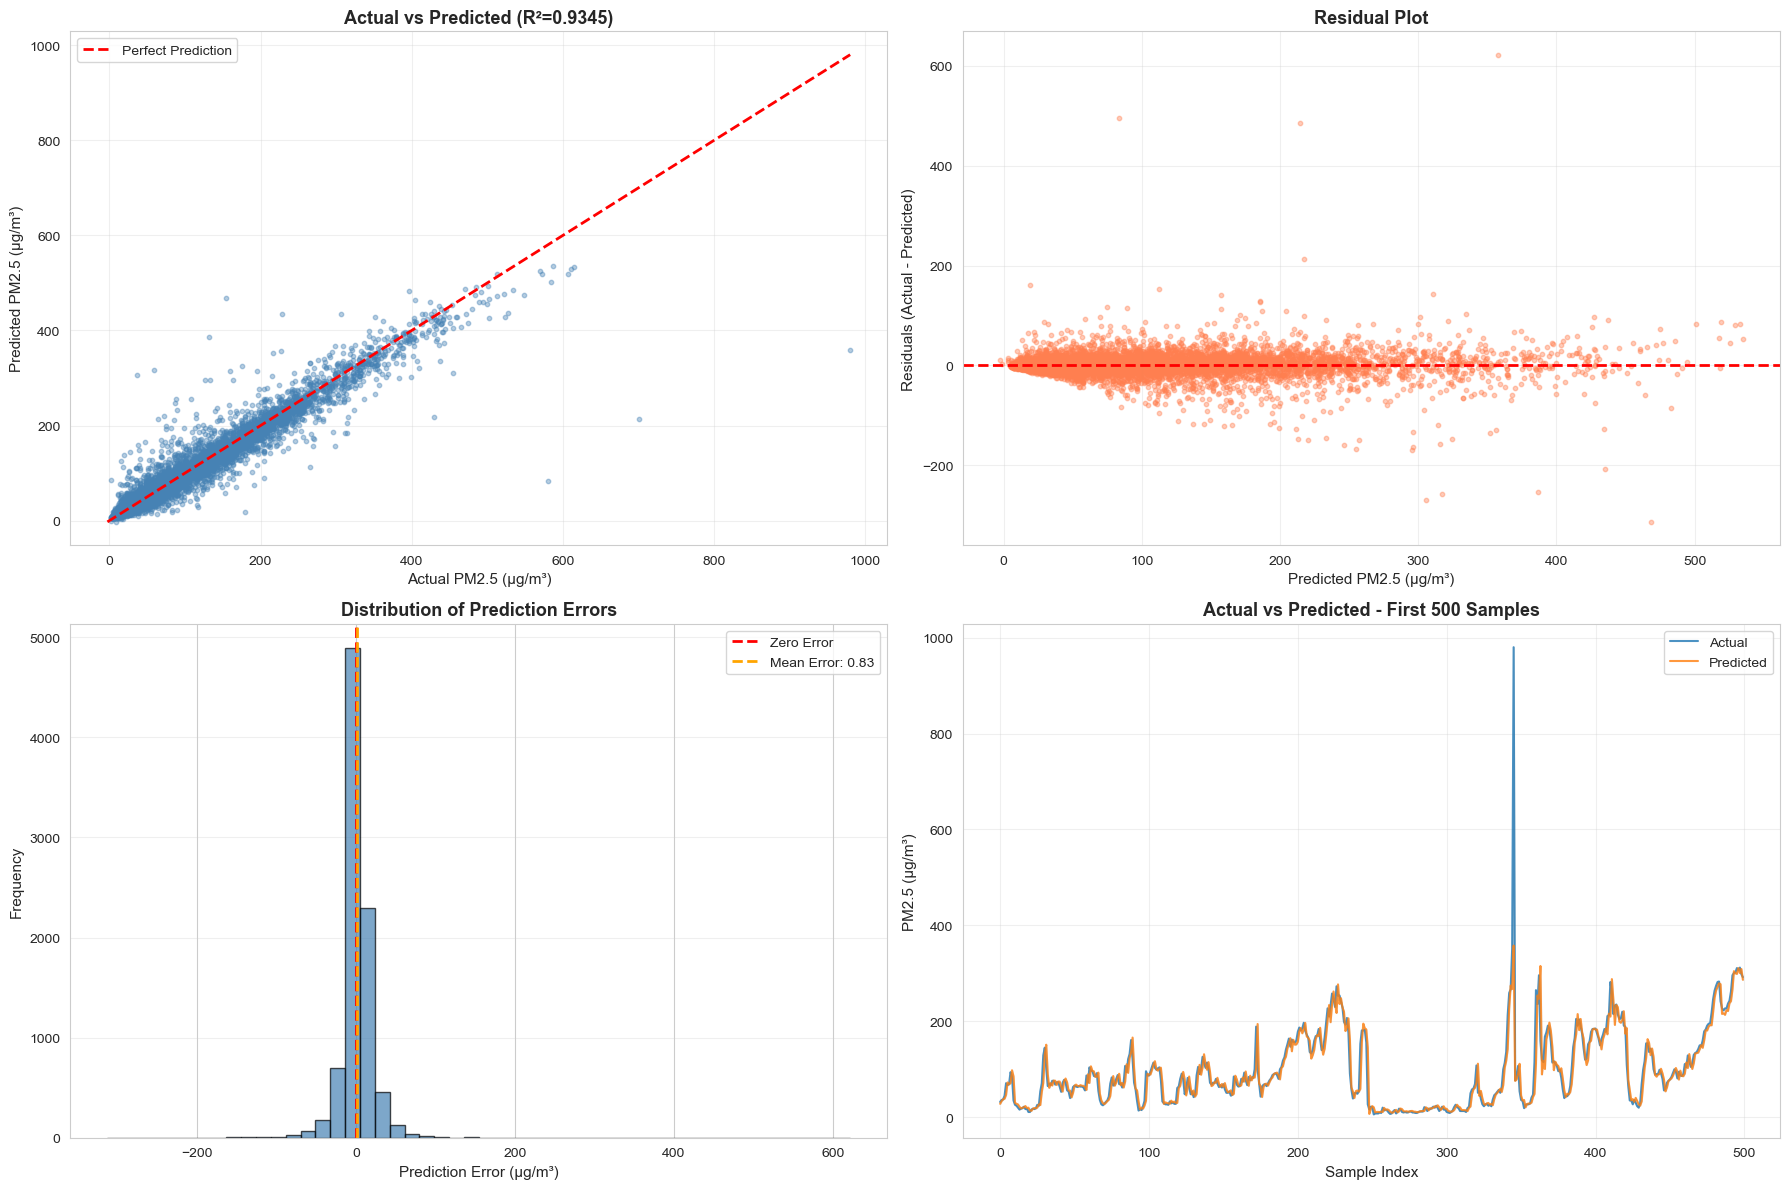

In [23]:
# Visualizzazioni predizioni
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred, alpha=0.4, s=10, color='steelblue')
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual PM2.5 (μg/m³)', fontsize=11)
ax1.set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=11)
ax1.set_title(f'Actual vs Predicted (R²={r2:.4f})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Residual Plot
ax2 = axes[0, 1]
ax2.scatter(y_pred, errors, alpha=0.4, s=10, color='coral')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted PM2.5 (μg/m³)', fontsize=11)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_title('Residual Plot', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Error Distribution
ax3 = axes[1, 0]
ax3.hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean Error: {errors.mean():.2f}')
ax3.set_xlabel('Prediction Error (μg/m³)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution of Prediction Errors', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Time Series: Prime 500 predizioni
ax4 = axes[1, 1]
n_show = min(500, len(y_test))
indices = np.arange(n_show)
ax4.plot(indices, y_test[:n_show], label='Actual', linewidth=1.5, alpha=0.8)
ax4.plot(indices, y_pred[:n_show], label='Predicted', linewidth=1.5, alpha=0.8)
ax4.fill_between(indices, 
                 y_test[:n_show].flatten(), 
                 y_pred[:n_show].flatten(), 
                 alpha=0.2, color='gray')
ax4.set_xlabel('Sample Index', fontsize=11)
ax4.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax4.set_title(f'Actual vs Predicted - First {n_show} Samples', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path('../figures/prediction/lstm_test_predictions.pdf'))
plt.show()


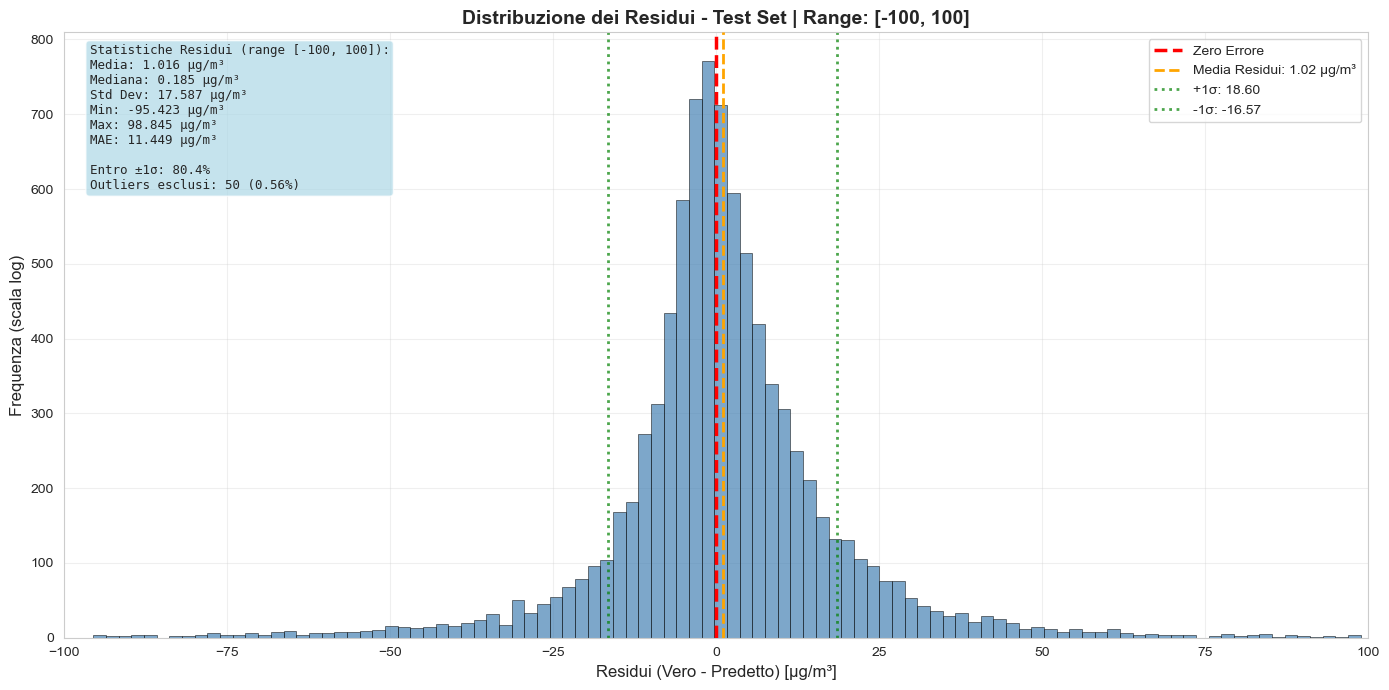


📊 GRAFICI RIASSUNTIVI COMPLETATI
✅ Residui: distribuzione con 100 bins
   → 69.4% dei residui entro ±MAE (12.33 μg/m³)
   → 86.5% dei residui entro ±1σ


In [ ]:
# Grafico riassuntivo: Istogramma Residui
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

residui = y_test.flatten() - y_pred.flatten()

# Limita i residui nell'intervallo [-100, 100]
residui_range = residui[(residui >= -100) & (residui <= 100)]
n_outliers = len(residui) - len(residui_range)

# Calcola bins ottimali
n_bins = min(100, int(np.sqrt(len(residui_range))) * 3)

counts, bins, patches = ax.hist(residui_range, bins=n_bins, color='steelblue', 
                                edgecolor='black', alpha=0.7, linewidth=0.5)

# Scala logaritmica sull'asse y
#ax.set_yscale('log')

# Linee di riferimento
ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error', zorder=5)
ax.axvline(x=residui_range.mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Mean Residual: {residui_range.mean():.2f} μg/m³', zorder=5)
ax.axvline(x=residui_range.mean() + residui_range.std(), color='green', linestyle=':', linewidth=2, 
           label=f'+1σ: {residui_range.mean() + residui_range.std():.2f}', alpha=0.7)
ax.axvline(x=residui_range.mean() - residui_range.std(), color='green', linestyle=':', linewidth=2, 
           label=f'-1σ: {residui_range.mean() - residui_range.std():.2f}', alpha=0.7)

# Imposta limiti asse x
ax.set_xlim(-100, 100)

ax.set_xlabel('Residuals (True - Predicted) [μg/m³]', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('Residuals Distribution - Test Set | Range: [-100, 100]', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='both', which='both')

# Statistiche residui come testo
residui_stats = f'''Residuals statistics (range [-100, 100]):
Mean: {residui_range.mean():.3f} μg/m³
Median: {np.median(residui_range):.3f} μg/m³
Std Dev: {residui_range.std():.3f} μg/m³
Min: {residui_range.min():.3f} μg/m³
Max: {residui_range.max():.3f} μg/m³
MAE: {np.abs(residui_range).mean():.3f} μg/m³

Within ±1σ: {(np.abs(residui_range - residui_range.mean()) <= residui_range.std()).sum()/len(residui_range)*100:.1f}%
Outliers excluded: {n_outliers} ({n_outliers/len(residui)*100:.2f}%)'''

ax.text(0.02, 0.98, residui_stats, transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()


print(f"Residui: distribuzione con {n_bins} bins")
print(f"   → {(np.abs(residui) <= mae).sum()/len(residui)*100:.1f}% dei residui entro ±MAE ({mae:.2f} μg/m³)")
print(f"   → {(np.abs(residui - residui.mean()) <= residui.std()).sum()/len(residui)*100:.1f}% dei residui entro ±1σ")


# Predizioni sul Dataset Originale Completo

Ora usiamo il modello LSTM addestrato per fare predizioni su **tutto** il dataset originale, timestamp per timestamp.

In [ ]:
def predict_on_full_dataset(df_original, model, window_size=100, scaler=None):
    """
    Fa predizioni su TUTTI i timestamp del dataset originale dove possibile.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        DataFrame originale completo
    model : keras.Model
        Modello LSTM addestrato
    window_size : int
        Dimensione finestra del modello
    scaler : StandardScaler
        Scaler per normalizzazione
    
    Returns:
    --------
    pd.Series : Serie con predizioni per tutti i timestamp predicibili
    dict : Statistiche delle predizioni
    """
    pm25_series = df_original['pm2.5'].copy()
    
    # Serie per le predizioni
    predictions_series = pd.Series(dtype=float, index=pd.DatetimeIndex([]))
    
    # Statistiche
    stats = {
        'total_timestamps': len(df_original),
        'predicted': 0,
        'failed_too_early': 0,  # Primi 100 timestamp
        'failed_missing_in_window': 0  # Finestra contiene missing
    }
    # Itera su tutti i timestamp (saltando i primi window_size)
    for pos in range(window_size, len(df_original)):
        idx = df_original.index[pos]
        
        # Estrai finestra di window_size valori precedenti
        window_start = pos - window_size
        window_data = pm25_series.iloc[window_start:pos]
        
        # Verifica che la finestra non contenga missing
        if window_data.isnull().any():
            stats['failed_missing_in_window'] += 1
            continue
        
        # Prepara input per il modello
        X_input = window_data.values.reshape(1, window_size, 1)
        
        # Normalizza
        if scaler is not None:
            X_input_flat = X_input.reshape(-1, 1)
            X_input_scaled = scaler.transform(X_input_flat)
            X_input = X_input_scaled.reshape(1, window_size, 1)
        
        # Predizione
        prediction = model.predict(X_input, verbose=0)[0, 0]
        
        # Salva predizione
        predictions_series.loc[idx] = prediction
        stats['predicted'] += 1
        
        # Progress bar ogni 5000 predizioni
        if stats['predicted'] % 5000 == 0:
            print(f"   → {stats['predicted']:,} predizioni completate...")
    
    stats['failed_too_early'] = window_size
    return predictions_series, stats

# Esegui predizioni su tutto il dataset
print("=" * 90)
full_predictions, full_stats = predict_on_full_dataset(
    df_original=df,
    model=final_model,
    window_size=WINDOW_SIZE,
    scaler=scaler
)

# Statistiche predizioni
if len(full_predictions) > 0:
    print(f"\nStatistiche Predizioni:")
    print(f"   Min:     {full_predictions.min():.2f} μg/m³")
    print(f"   Max:     {full_predictions.max():.2f} μg/m³")
    print(f"   Media:   {full_predictions.mean():.2f} μg/m³")
    print(f"   Mediana: {full_predictions.median():.2f} μg/m³")
    print(f"   Std:     {full_predictions.std():.2f} μg/m³")
    print(f"\nPeriodo coperto:")
    print(f"   Dal: {full_predictions.index.min()}")
    print(f"   Al:  {full_predictions.index.max()}")


🔮 Predizione su 43,824 timestamps del dataset originale...
   Finestra richiesta: 100 valori precedenti
   → 5,000 predizioni completate...
   → 10,000 predizioni completate...
   → 15,000 predizioni completate...
   → 20,000 predizioni completate...
   → 25,000 predizioni completate...

✅ Predizioni completate!
   Predizioni riuscite:              28,966
   Non predicibili (primi 100):   100
   Non predicibili (missing in window): 14,758

RIEPILOGO PREDIZIONI DATASET COMPLETO
   Timestamp totali:                43,824
   Predizioni generate:             28,966 (66.10%)
   Non predicibili (inizio dataset): 100
   Non predicibili (finestra manca): 14,758

Statistiche Predizioni:
   Min:     -4.86 μg/m³
   Max:     564.60 μg/m³
   Media:   96.78 μg/m³
   Mediana: 71.56 μg/m³
   Std:     87.51 μg/m³

Periodo coperto:
   Dal: 2010-01-06 04:00:00
   Al:  2014-12-31 23:00:00


In [ ]:
# Crea DataFrame Finale Unificato
df_final = pd.DataFrame(index=df.index)

# 1. Valori originali PM2.5
df_final['pm2.5_original'] = df['pm2.5']

# 2. Predizioni LSTM su tutto il dataset
df_final['pm2.5_lstm_full'] = full_predictions

# 3. Classifica ogni timestamp
def classify_timestamp(row):
    """Classifica ogni timestamp"""
    has_original = pd.notna(row['pm2.5_original'])
    has_prediction = pd.notna(row['pm2.5_lstm_full'])
    
    if has_original and has_prediction:
        return 'both'  # Valore originale + predizione disponibili
    elif has_original and not has_prediction:
        return 'original_only'  # Solo valore originale
    elif not has_original and has_prediction:
        return 'prediction_only'  # Solo predizione (impossibile in questo caso)
    else:
        return 'no_data'  # Né originale né predizione

df_final['data_type'] = df_final.apply(classify_timestamp, axis=1)

# Statistiche
print("=" * 90)
print("DATASET FINALE UNIFICATO")
print("=" * 90)
print(f"Shape: {df_final.shape}")
print(f"\nColonne:")
print(f"   • pm2.5_original:   Valori originali dal dataset Beijing")
print(f"   • pm2.5_lstm_full:  Predizioni LSTM su tutto il dataset")
print(f"   • data_type:        Tipo di dato disponibile")
print("=" * 90)

print(f"\nDistribuzione Tipi di Dato:")
type_counts = df_final['data_type'].value_counts()
for dtype, count in type_counts.items():
    pct = count / len(df_final) * 100
    print(f"   {dtype:20s}: {count:6,} ({pct:5.2f}%)")
print("=" * 90)

# Calcola errori dove abbiamo entrambi i valori
both_mask = df_final['data_type'] == 'both'
n_both = both_mask.sum()

if n_both > 0:
    original_both = df_final.loc[both_mask, 'pm2.5_original']
    pred_both = df_final.loc[both_mask, 'pm2.5_lstm_full']
    
    mae_full = mean_absolute_error(original_both, pred_both)
    rmse_full = np.sqrt(mean_squared_error(original_both, pred_both))
    r2_full = r2_score(original_both, pred_both)
    
    print(f"\nMetriche su Timestamp con Entrambi i Valori:")
    print(f"   N. timestamps: {n_both:,}")
    print(f"   MAE:           {mae_full:.4f} μg/m³")
    print(f"   RMSE:          {rmse_full:.4f} μg/m³")
    print(f"   R²:            {r2_full:.4f}")
    print("=" * 90)

print(f"\nEsempio dati:")
print(df_final.head(120))


DATASET FINALE UNIFICATO
Shape: (43824, 3)

Colonne:
   • pm2.5_original:   Valori originali dal dataset Beijing
   • pm2.5_lstm_full:  Predizioni LSTM su tutto il dataset
   • data_type:        Tipo di dato disponibile

Distribuzione Tipi di Dato:
   both                : 28,871 (65.88%)
   original_only       : 12,886 (29.40%)
   no_data             :  1,972 ( 4.50%)
   prediction_only     :     95 ( 0.22%)

✅ Metriche su Timestamp con Entrambi i Valori:
   N. timestamps: 28,871
   MAE:           12.2977 μg/m³
   RMSE:          22.5834 μg/m³
   R²:            0.9380

Esempio dati:
                     pm2.5_original  pm2.5_lstm_full      data_type
datetime                                                           
2010-01-01 00:00:00             NaN              NaN        no_data
2010-01-01 01:00:00             NaN              NaN        no_data
2010-01-01 02:00:00             NaN              NaN        no_data
2010-01-01 03:00:00             NaN              NaN        no_data
20

start tmp

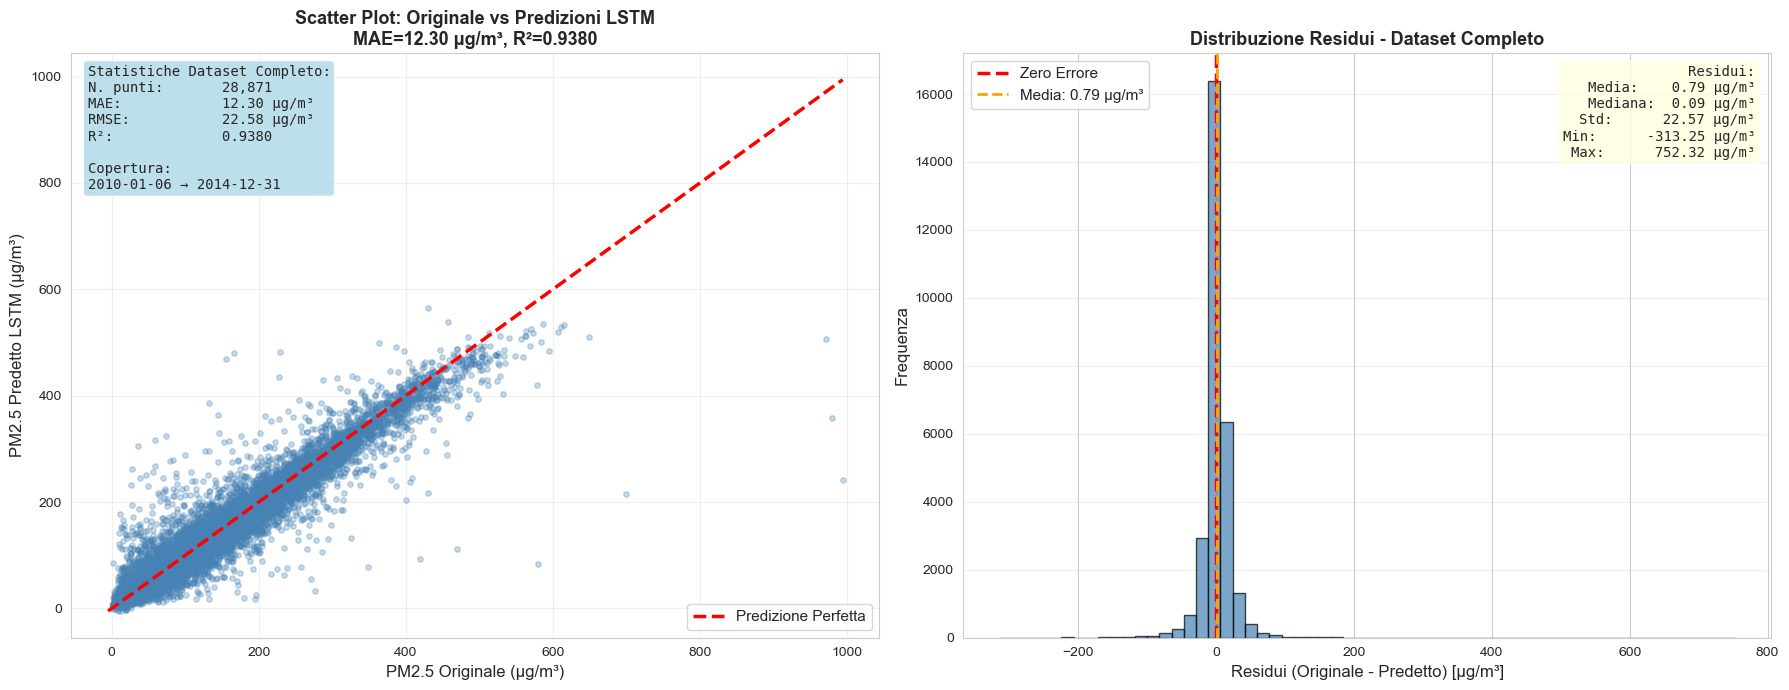


✅ ANALISI COMPLETA TERMINATA

DataFrame finale 'df_final' contiene:
   • 43,824 timestamp totali
   • 28,871 timestamp con originale + predizione
   • 12,886 timestamp solo originale
   • 95 timestamp solo predizione
   • 1,972 timestamp senza dati


# Predizione Iterativa dei Missing Rimasti

Ora prediciamo i missing values rimasti usando un approccio iterativo: se mancano valori nella finestra dei 100 precedenti, usiamo le predizioni già fatte per riempire quei gap.

In [ ]:
def predict_missing_iterative(df_original, existing_predictions, model, window_size=100, scaler=None):
    """
    Predice i missing values rimasti usando un approccio ITERATIVO:
    - Se la finestra contiene missing, li riempiamo con le predizioni già fatte
    - Ogni nuova predizione viene usata per predire i successivi missing
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        DataFrame originale con missing values
    existing_predictions : pd.Series
        Serie con predizioni già fatte (da predict_on_full_dataset)
    model : keras.Model
        Modello LSTM addestrato
    window_size : int
        Dimensione finestra del modello
    scaler : StandardScaler
        Scaler per normalizzazione
    
    Returns:
    --------
    pd.Series : Serie con NUOVE predizioni per missing rimasti
    dict : Statistiche delle predizioni
    """
    # Crea serie combinata: originali + predizioni esistenti
    combined_series = df_original['pm2.5'].copy()
    
    # Riempi missing con predizioni esistenti dove disponibili
    missing_mask = combined_series.isnull()
    combined_series[missing_mask] = existing_predictions[missing_mask]
    
    # Serie per NUOVE predizioni (solo missing rimasti)
    new_predictions = pd.Series(dtype=float, index=pd.DatetimeIndex([]))
    
    # Statistiche
    stats = {
        'total_missing_remaining': combined_series.isnull().sum(),
        'predicted': 0,
        'failed_too_early': 0,
        'iterations': 0
    }
    
    print(f"   Missing iniziali rimasti: {stats['total_missing_remaining']:,}")
    
    # Itera finché ci sono missing da predire
    max_iterations = 10  # Limite di sicurezza
    iteration = 0
    previous_missing = stats['total_missing_remaining']
    
    while combined_series.isnull().sum() > 0 and iteration < max_iterations:
        iteration += 1
        missing_at_start = combined_series.isnull().sum()
        predictions_this_iter = 0
        
        print(f"\n   Iterazione {iteration}: {missing_at_start:,} missing da processare...")
        
        # Trova tutti i missing rimasti
        missing_indices = combined_series[combined_series.isnull()].index
        
        for idx in missing_indices:
            # Trova posizione
            pos = df_original.index.get_loc(idx)
            
            # Salta se troppo vicino all'inizio
            if pos < window_size:
                stats['failed_too_early'] += 1
                continue
            
            # Estrai finestra di window_size valori precedenti
            window_start = pos - window_size
            window_data = combined_series.iloc[window_start:pos]
            
            # Se la finestra contiene ancora missing, salta per ora
            if window_data.isnull().any():
                continue
            
            # Prepara input per il modello
            X_input = window_data.values.reshape(1, window_size, 1)
            
            # Normalizza
            if scaler is not None:
                X_input_flat = X_input.reshape(-1, 1)
                X_input_scaled = scaler.transform(X_input_flat)
                X_input = X_input_scaled.reshape(1, window_size, 1)
            
            # Predizione
            prediction = model.predict(X_input, verbose=0)[0, 0]
            
            # Salva nella serie combinata (per prossime iterazioni)
            combined_series.iloc[pos] = prediction
            
            # Salva nelle NUOVE predizioni
            new_predictions.loc[idx] = prediction
            
            stats['predicted'] += 1
            predictions_this_iter += 1
        
        print(f"      → Predetti: {predictions_this_iter:,}")
        
        # Se non abbiamo fatto progressi, esci
        if predictions_this_iter == 0:
            print(f"Nessun progresso, uscita dall'iterazione")
            break
        
        stats['iterations'] = iteration
    
    missing_final = combined_series.isnull().sum()
    return new_predictions, stats, combined_series

# Esegui predizione iterativa
print("=" * 90)
iterative_predictions, iterative_stats, full_combined = predict_missing_iterative(
    df_original=df,
    existing_predictions=full_predictions,
    model=final_model,
    window_size=WINDOW_SIZE,
    scaler=scaler
)

print("\n" + "=" * 90)
print("=" * 90)
print(f"   Missing rimasti da processare:       {iterative_stats['total_missing_remaining']:,}")
print(f"   Nuove predizioni generate:           {iterative_stats['predicted']:,}")
print(f"   Missing ancora irrisolti:            {full_combined.isnull().sum():,}")
print("=" * 90)

if len(iterative_predictions) > 0:
    print(f"\nStatistiche NUOVE Predizioni Iterative:")
    print(f"   Min:     {iterative_predictions.min():.2f} μg/m³")
    print(f"   Max:     {iterative_predictions.max():.2f} μg/m³")
    print(f"   Media:   {iterative_predictions.mean():.2f} μg/m³")
    print(f"   Mediana: {iterative_predictions.median():.2f} μg/m³")
    print(f"   Std:     {iterative_predictions.std():.2f} μg/m³")


🔮 Predizione ITERATIVA dei missing rimasti...
   Missing iniziali rimasti: 1,972
   Finestra richiesta: 100 valori

   Iterazione 1: 1,972 missing da processare...
      → Predetti: 1,948

   Iterazione 2: 24 missing da processare...
      → Predetti: 0
      ⚠️  Nessun progresso, uscita dall'iterazione

✅ Predizione iterativa completata!
   Iterazioni eseguite:              1
   NUOVE predizioni generate:        1,948
   Missing ancora irrisolti:         24
   Non predicibili (troppo all'inizio): 48

RIEPILOGO PREDIZIONE ITERATIVA
   Missing rimasti da processare:       1,972
   Nuove predizioni generate:           1,948
   Iterazioni necessarie:               1
   Missing ancora irrisolti:            24

Statistiche NUOVE Predizioni Iterative:
   Min:     7.77 μg/m³
   Max:     435.17 μg/m³
   Media:   94.16 μg/m³
   Mediana: 95.67 μg/m³
   Std:     44.20 μg/m³


In [101]:
# Aggiorna DataFrame finale con le predizioni iterative
df_final['pm2.5_lstm_iterative'] = iterative_predictions

# Riclassifica i tipi di dato
def classify_timestamp_extended(row):
    """Classifica ogni timestamp con le nuove predizioni iterative"""
    has_original = pd.notna(row['pm2.5_original'])
    has_pred_full = pd.notna(row['pm2.5_lstm_full'])
    has_pred_iter = pd.notna(row['pm2.5_lstm_iterative'])
    
    if has_original and has_pred_full:
        return 'both'  # Originale + predizione standard
    elif has_original and not has_pred_full:
        return 'original_only'  # Solo originale
    elif not has_original and has_pred_full:
        return 'prediction_only'  # Solo predizione standard (95 punti)
    elif not has_original and has_pred_iter:
        return 'iterative_prediction'  # NUOVA: predizione iterativa
    else:
        return 'no_data'  # Ancora missing

df_final['data_type_extended'] = df_final.apply(classify_timestamp_extended, axis=1)

# Statistiche
print("=" * 90)
print("DATASET FINALE CON PREDIZIONI ITERATIVE")
print("=" * 90)
print(f"Shape: {df_final.shape}")
print(f"\nColonne:")
print(f"   • pm2.5_original:         Valori originali dal dataset Beijing")
print(f"   • pm2.5_lstm_full:        Predizioni LSTM standard (su finestre complete)")
print(f"   • pm2.5_lstm_iterative:   Predizioni LSTM iterative (su finestre parziali)")
print(f"   • data_type_extended:     Tipo di dato disponibile (esteso)")
print("=" * 90)

print(f"\nDistribuzione Tipi di Dato ESTESA:")
type_counts_ext = df_final['data_type_extended'].value_counts().sort_index()
for dtype, count in type_counts_ext.items():
    pct = count / len(df_final) * 100
    print(f"   {dtype:25s}: {count:6,} ({pct:5.2f}%)")
print("=" * 90)

# Calcola copertura totale
total_data = (df_final['data_type_extended'] != 'no_data').sum()
print(f"\n✅ Copertura Totale Dataset:")
print(f"   Timestamp con dati (originali o predetti): {total_data:,} / {len(df_final):,} ({total_data/len(df_final)*100:.2f}%)")
print(f"   Missing ancora irrisolti:                  {(df_final['data_type_extended']=='no_data').sum():,} ({(df_final['data_type_extended']=='no_data').sum()/len(df_final)*100:.2f}%)")
print("=" * 90)

print(f"\nEsempio primi 150 timestamp:")
print(df_final[['pm2.5_original', 'pm2.5_lstm_full', 'pm2.5_lstm_iterative', 'data_type_extended']].head(150))


DATASET FINALE CON PREDIZIONI ITERATIVE
Shape: (43824, 5)

Colonne:
   • pm2.5_original:         Valori originali dal dataset Beijing
   • pm2.5_lstm_full:        Predizioni LSTM standard (su finestre complete)
   • pm2.5_lstm_iterative:   Predizioni LSTM iterative (su finestre parziali)
   • data_type_extended:     Tipo di dato disponibile (esteso)

Distribuzione Tipi di Dato ESTESA:
   both                     : 28,871 (65.88%)
   iterative_prediction     :  1,948 ( 4.45%)
   no_data                  :     24 ( 0.05%)
   original_only            : 12,886 (29.40%)
   prediction_only          :     95 ( 0.22%)

✅ Copertura Totale Dataset:
   Timestamp con dati (originali o predetti): 43,800 / 43,824 (99.95%)
   Missing ancora irrisolti:                  24 (0.05%)

Esempio primi 150 timestamp:
                     pm2.5_original  pm2.5_lstm_full  pm2.5_lstm_iterative  \
datetime                                                                     
2010-01-01 00:00:00             NaN    

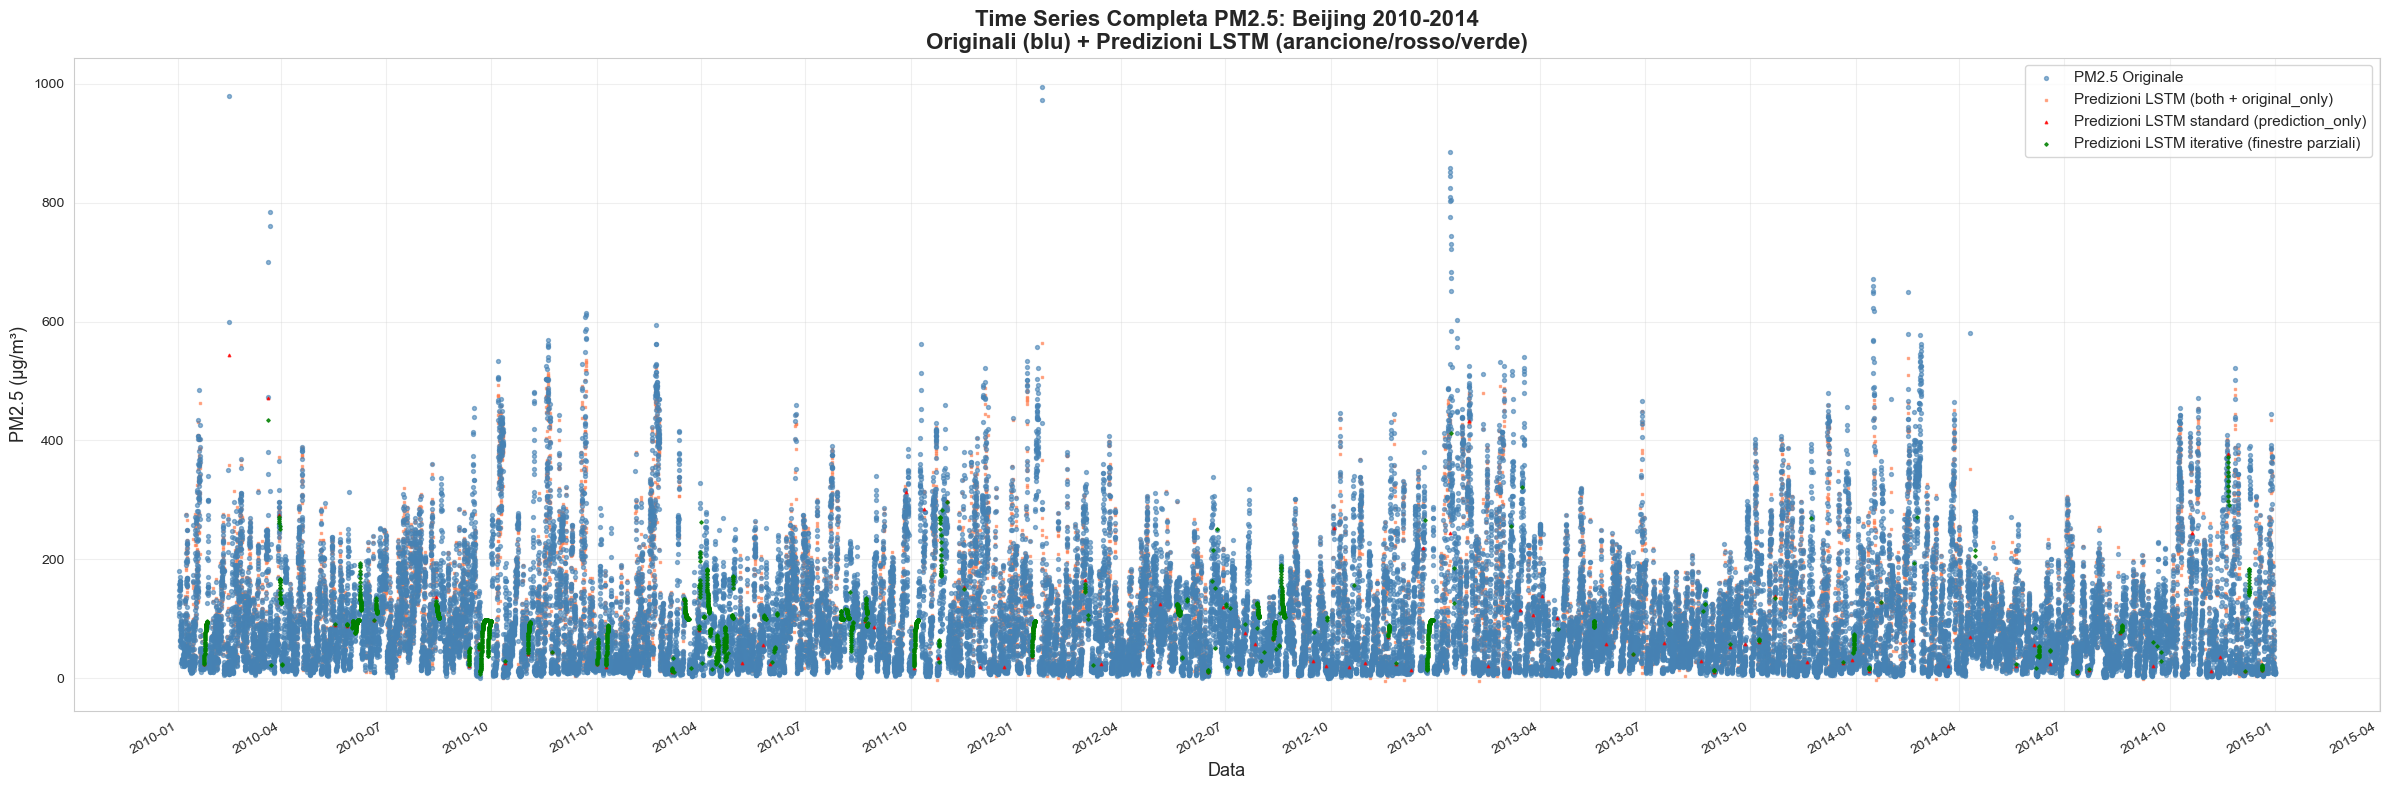

STATISTICHE TIME SERIES COMPLETA (con predizioni iterative)

Dati visualizzati:
   • Originali (blu):                      41,757 punti
   • Predizioni both+original (arancione):  28,871 punti
   • Predizioni prediction_only (rosso):   95 punti
   • Predizioni iterative (verde):         1,948 punti

Totale punti visualizzati:                72,671
Periodo:                                  2010-01-01 00:00:00 → 2014-12-31 23:00:00

Copertura finale:                         99.95%
Missing irrisolti:                        24 (0.05%)


In [105]:
# Visualizzazione Time Series COMPLETA con TUTTE le categorie
fig, ax = plt.subplots(figsize=(24, 8))

# 1. VALORI ORIGINALI in BLU
original_mask = df_final['pm2.5_original'].notna()
ax.scatter(df_final.index[original_mask], 
          df_final.loc[original_mask, 'pm2.5_original'],
          s=8, alpha=0.6, color='steelblue', 
          label='PM2.5 Originale', zorder=3)

# 2. PREDIZIONI per categorie 'both' e 'original_only' in ARANCIONE
both_and_orig_mask = df_final['data_type_extended'].isin(['both', 'original_only']) & df_final['pm2.5_lstm_full'].notna()
ax.scatter(df_final.index[both_and_orig_mask], 
          df_final.loc[both_and_orig_mask, 'pm2.5_lstm_full'],
          s=3, alpha=0.6, color='coral', marker='s',
          label='Predizioni LSTM (both + original_only)', zorder=2)

# 3. PREDIZIONI per categoria 'prediction_only' in ROSSO
pred_only_mask = df_final['data_type_extended'] == 'prediction_only'
ax.scatter(df_final.index[pred_only_mask], 
          df_final.loc[pred_only_mask, 'pm2.5_lstm_full'],
          s=3, alpha=0.8, color='red', marker='^',
          label='Predizioni LSTM standard (prediction_only)', zorder=4)

# 4. PREDIZIONI ITERATIVE in VERDE (NUOVA CATEGORIA!)
iter_pred_mask = df_final['data_type_extended'] == 'iterative_prediction'
ax.scatter(df_final.index[iter_pred_mask], 
          df_final.loc[iter_pred_mask, 'pm2.5_lstm_iterative'],
          s=3, alpha=0.8, color='green', marker='D',
          label='Predizioni LSTM iterative (finestre parziali)', zorder=5)

# Formattazione
ax.set_title('Time Series Completa PM2.5: Beijing 2010-2014\nOriginali (blu) + Predizioni LSTM (arancione/rosso/verde)', 
            fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=13)
ax.set_ylabel('PM2.5 (μg/m³)', fontsize=13)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

# Formatta asse x per date
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig(Path('../figures/prediction/full_timeseries_complete_with_iterative.pdf'), dpi=150)
plt.show()

# Stampa statistiche
print("=" * 90)
print("STATISTICHE TIME SERIES COMPLETA (con predizioni iterative)")
print("=" * 90)
print(f"\nDati visualizzati:")
print(f"   • Originali (blu):                      {original_mask.sum():,} punti")
print(f"   • Predizioni both+original (arancione):  {both_and_orig_mask.sum():,} punti")
print(f"   • Predizioni prediction_only (rosso):   {pred_only_mask.sum():,} punti")
print(f"   • Predizioni iterative (verde):         {iter_pred_mask.sum():,} punti")
print(f"\nTotale punti visualizzati:                {original_mask.sum() + both_and_orig_mask.sum() + pred_only_mask.sum() + iter_pred_mask.sum():,}")
print(f"Periodo:                                  {df_final.index.min()} → {df_final.index.max()}")
print(f"\nCopertura finale:                         {((df_final['data_type_extended'] != 'no_data').sum() / len(df_final) * 100):.2f}%")
print(f"Missing irrisolti:                        {(df_final['data_type_extended'] == 'no_data').sum():,} ({(df_final['data_type_extended'] == 'no_data').sum() / len(df_final) * 100:.2f}%)")
print("=" * 90)


In [115]:
# Selezione casuale di 5 periodi di 3 mesi per visualizzazione dettagliata
import random
from dateutil.relativedelta import relativedelta

# Imposta seed per riproducibilità
random.seed(42)
np.random.seed(42)

# Periodo disponibile nel dataset
date_min = df_final.index.min()
date_max = df_final.index.max()

# Genera 5 date di inizio casuali per periodi di 3 mesi
periodo_durata = relativedelta(months=2)
n_periodi = 5

# Calcola il range valido per le date di inizio (almeno 3 mesi prima della fine)
date_max_start = date_max - periodo_durata

# Genera date di inizio casuali
periodi_dettaglio = []
for i in range(n_periodi):
    # Converti in timestamp per campionamento uniforme
    start_ts = date_min.timestamp()
    end_ts = date_max_start.timestamp()
    
    random_ts = random.uniform(start_ts, end_ts)
    random_date = pd.Timestamp(random_ts, unit='s', tz=date_min.tz)
    
    # Calcola fine periodo
    periodo_fine = random_date + periodo_durata
    
    periodi_dettaglio.append({
        'id': i + 1,
        'inizio': random_date,
        'fine': periodo_fine
    })

print("=" * 90)
print("PERIODI SELEZIONATI PER VISUALIZZAZIONE DETTAGLIATA")
print("=" * 90)
for p in periodi_dettaglio:
    print(f"Periodo {p['id']}: {p['inizio'].strftime('%Y-%m-%d')} → {p['fine'].strftime('%Y-%m-%d')}")
print("=" * 90)


PERIODI SELEZIONATI PER VISUALIZZAZIONE DETTAGLIATA
Periodo 1: 2013-02-02 → 2013-04-02
Periodo 2: 2010-02-14 → 2010-04-14
Periodo 3: 2011-05-01 → 2011-07-01
Periodo 4: 2011-01-29 → 2011-03-29
Periodo 5: 2013-07-23 → 2013-09-23


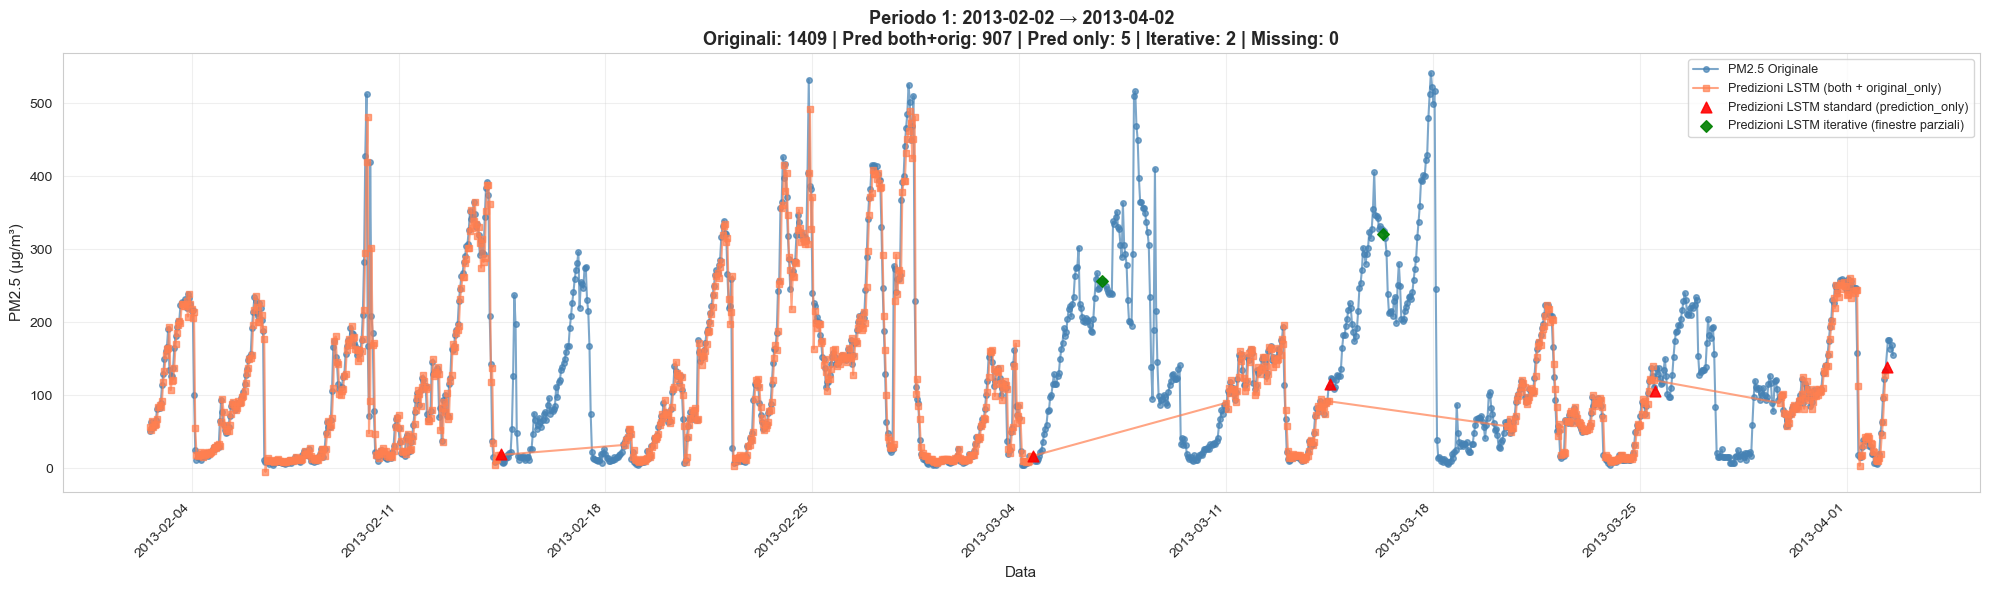

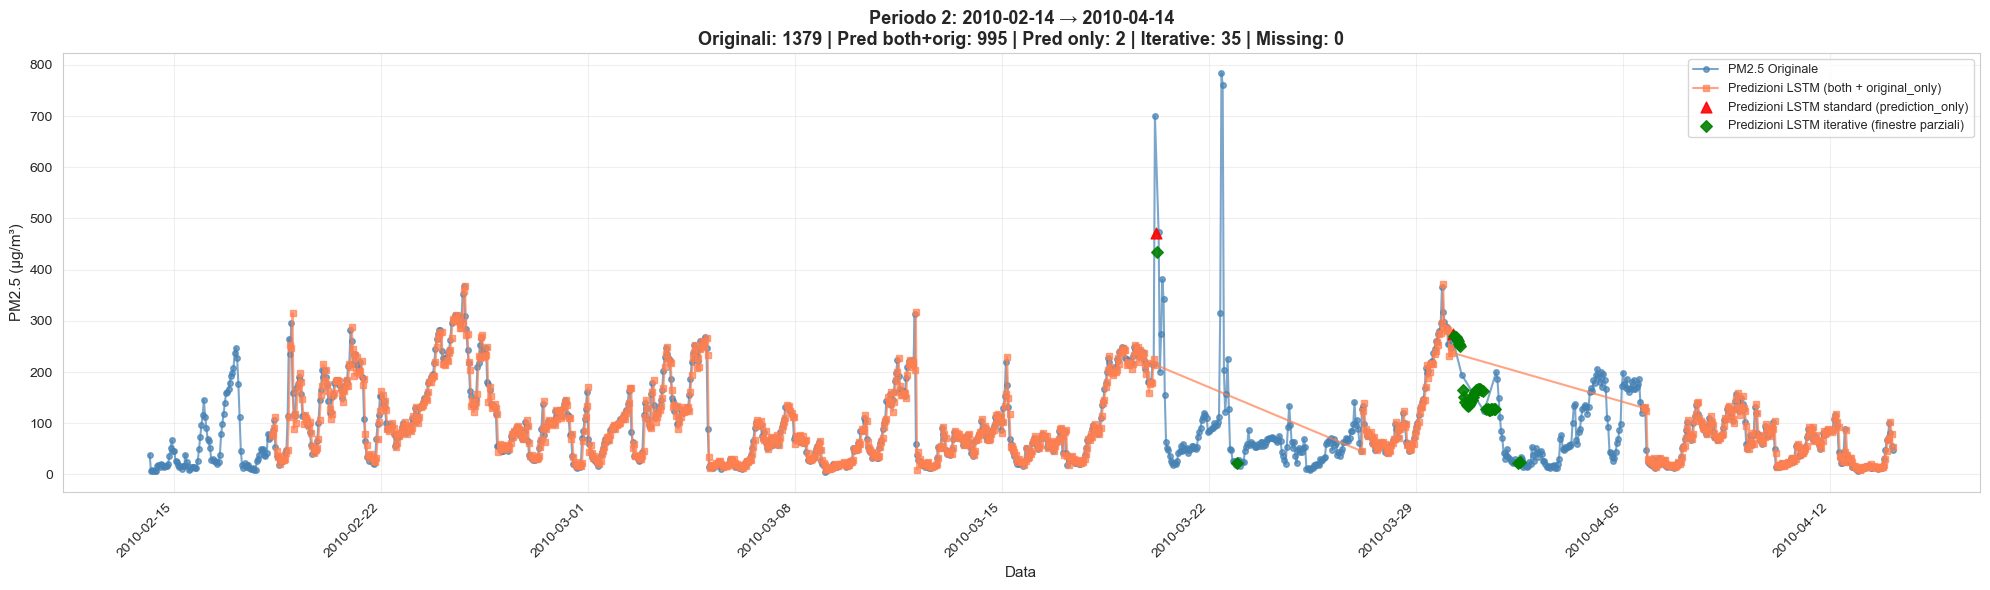

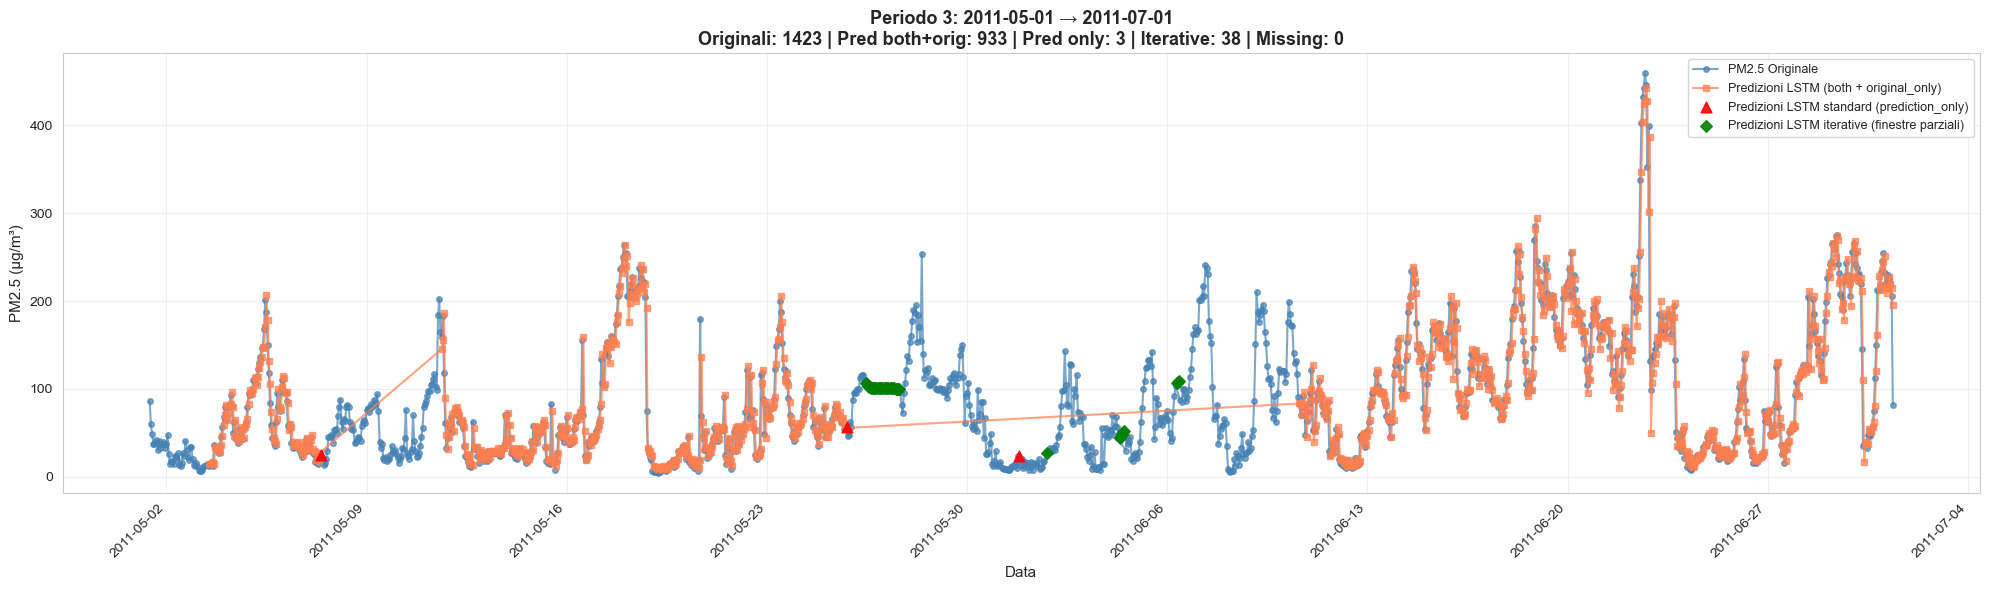

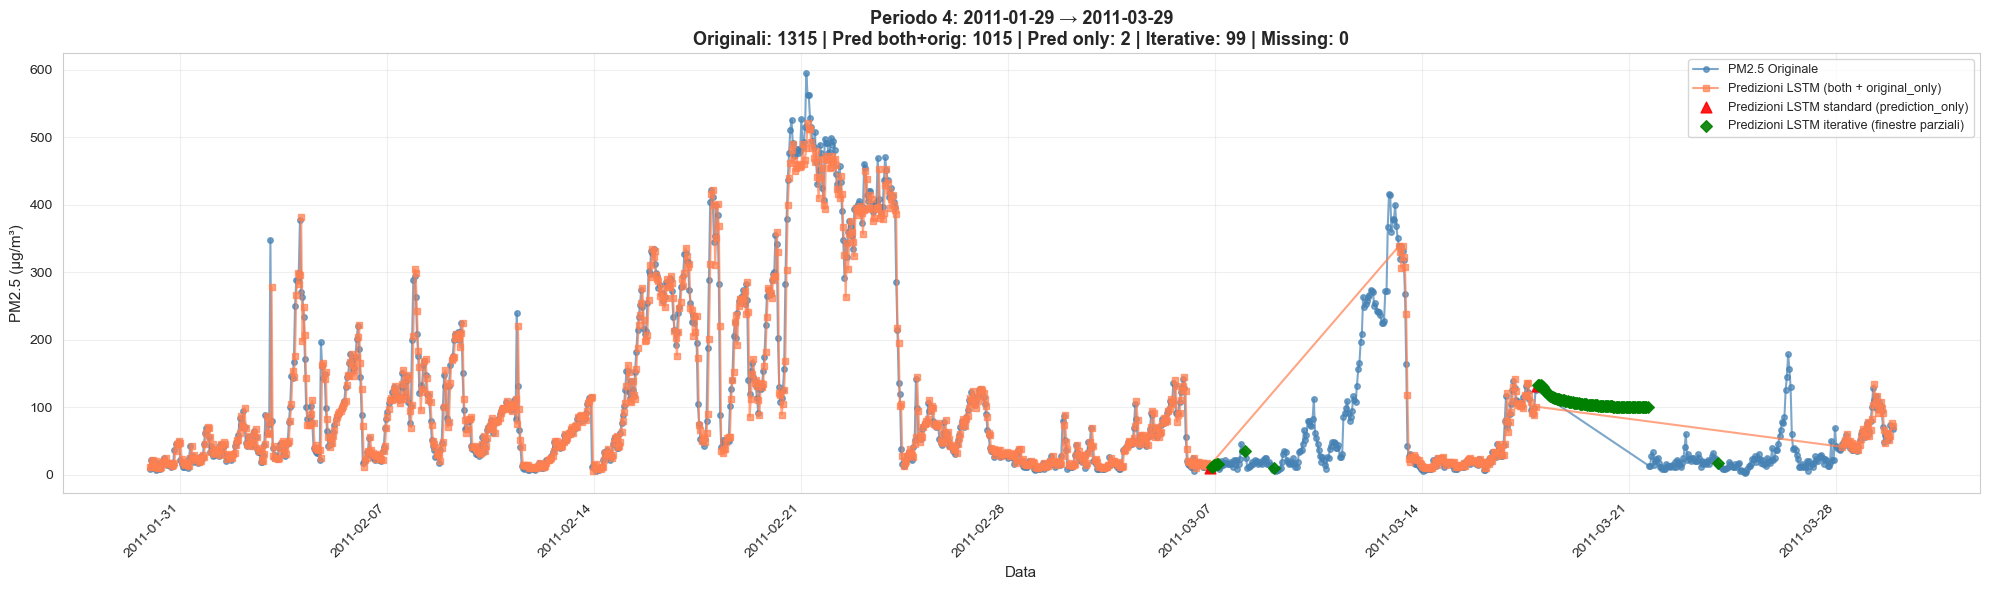

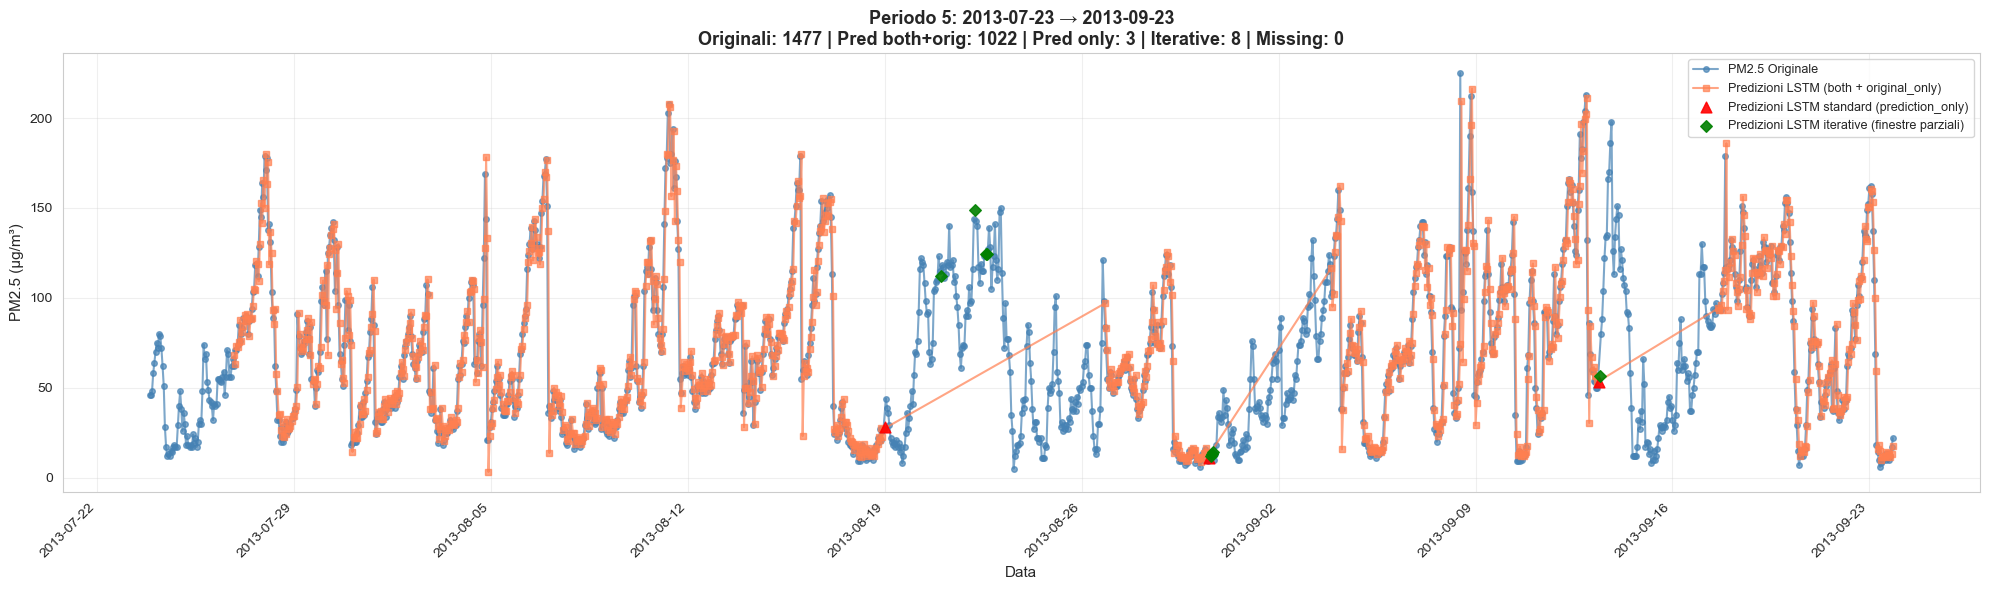

In [134]:
# Visualizza i 5 periodi dettagliati
import matplotlib.dates as mdates

# Assicura DatetimeIndex globale
df_final.index = pd.to_datetime(df_final.index)

for p in periodi_dettaglio:

    # Estrai dati per il periodo (copiato per sicurezza)
    periodo_data = df_final.loc[p['inizio']:p['fine']].copy()
    periodo_data.index = pd.to_datetime(periodo_data.index)

    fig, ax = plt.subplots(figsize=(20, 6))

    # ===== 1. VALORI ORIGINALI (BLU) =====
    y = periodo_data['pm2.5_original']
    mask = y.notna()
    if mask.sum() > 0:
        ax.plot(
            periodo_data.index[mask], y[mask],
            'o-', color='steelblue',
            markersize=4, linewidth=1.5, alpha=0.7,
            label='PM2.5 Originale', zorder=1
        )

    # ===== 2. PREDIZIONI both+original (ARANCIONE) =====
    mask = periodo_data['data_type_extended'].isin(['both', 'original_only'])
    y = periodo_data.loc[mask, 'pm2.5_lstm_full']
    mask2 = y.notna()
    if mask2.sum() > 0:
        ax.plot(
            y.index[mask2], y[mask2],
            's-', color='coral',
            markersize=4, linewidth=1.5, alpha=0.7,
            label='Predizioni LSTM (both + original_only)', zorder=2
        )

    # ===== 3. PREDIZIONI prediction_only (ROSSO, solo scatter) =====
    mask = periodo_data['data_type_extended'] == 'prediction_only'
    y = periodo_data.loc[mask, 'pm2.5_lstm_full']
    if y.notna().sum() > 0:
        ax.scatter(
            y.index, y.values,
            c='red', marker='^', s=60, alpha=0.9,
            label='Predizioni LSTM standard (prediction_only)', zorder=4
        )

    # ===== 4. PREDIZIONI ITERATIVE (VERDE, solo scatter) =====
    mask = periodo_data['data_type_extended'] == 'iterative_prediction'
    y = periodo_data.loc[mask, 'pm2.5_lstm_iterative']
    if y.notna().sum() > 0:
        ax.scatter(
            y.index, y.values,
            c='green', marker='D', s=35, alpha=0.9,
            label='Predizioni LSTM iterative (finestre parziali)', zorder=5
        )

    # ===== STATISTICHE =====
    n_original  = periodo_data['pm2.5_original'].notna().sum()
    n_both_orig = periodo_data.loc[
        periodo_data['data_type_extended'].isin(['both', 'original_only']),
        'pm2.5_lstm_full'
    ].notna().sum()

    n_pred_only = (periodo_data['data_type_extended'] == 'prediction_only').sum()
    n_iter      = (periodo_data['data_type_extended'] == 'iterative_prediction').sum()
    n_missing   = (periodo_data['data_type_extended'] == 'no_data').sum()

    periodo_str = f"{p['inizio'].strftime('%Y-%m-%d')} → {p['fine'].strftime('%Y-%m-%d')}"

    title = (
        f"Periodo {p['id']}: {periodo_str}\n"
        f"Originali: {n_original} | Pred both+orig: {n_both_orig} | "
        f"Pred only: {n_pred_only} | Iterative: {n_iter} | Missing: {n_missing}"
    )

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Data', fontsize=11)
    ax.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)

    # tick principali → 1 a settimana (lunedì di default)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # tick secondari → ogni giorno
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    # rotazione etichette principali


    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(Path(f'../figures/prediction/detail_period_{p["id"]}.pdf'), dpi=150)
    plt.show()
